# Deep Learning CA1: Fashion MNIST

I start by installing a few extra libraries which I will use later on in the notebook. The key library here is Tensorflow Addons, which extends Tensorflow and Keras to include implementations of more advanced deep learning advances.

In [1]:
!pip install -q -U keras-tuner tensorflow_addons

     |████████████████████████████████| 98 kB 5.6 MB/s 
     |████████████████████████████████| 1.1 MB 80.0 MB/s 


To train my model, I make use of Google Colab. I run the cell below to ensure that GPU hardware is enabled.

In [2]:
!nvidia-smi

Sun Nov 28 06:24:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Library Imports
I begin by importanting essential libraries. These are:
- NumPy: use for numerical computations
- Matplotlib: use for plotting
- Pandas: we use this to store our model results
- Plotly: use for plotting
- Tensorflow: Keras with a Tensorflow backend is the primary deep learning library used
- Seaborn: use for plotting

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow import expand_dims
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Normalization, Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D, Dropout, BatchNormalization, ReLU, Layer, Reshape, Flatten, Activation, Multiply, Resizing, Lambda, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TerminateOnNaN, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.resnet_v2 import ResNet101V2, preprocess_input
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts, CosineDecay
import keras_tuner as kt
from tensorflow_addons.activations import mish
from tensorflow_addons.optimizers import SWA, AdaBelief
from tensorflow_addons.layers import StochasticDepth
from tensorflow.image import random_flip_left_right, random_crop, resize_with_crop_or_pad


## Setting Random Seed
To allow for improved reproducibility, I make sure to set a random seed. 42 is the answer to everything in the universe.

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

## Problem Statement
Our problem statement is to develop a deep learning model that is capable of classifiying items of clothing, from the Fashion MNIST data set.

### What is [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)?
Fashion MNIST is a dataset containing images of articles of clothing from the fashion company [Zalando](https://www.zalando.co.uk/). It was designed to be a drop in replacement for the MNIST dataset, which was a dataset on handwritten digits. MNIST was widely used as a benchmark for machine learning algorithms, but had a key flaw:
>It was very easy, to the point where even classical machine learning models could classify it with good accuracy

So, Zalando developed the Fashion MNIST dataset to replace the original MNIST dataset as a better benchmark.
### What are our goals for the model?
Our goals for the model are to develop a model that is able to generalize well to new data points (that is, does not overfit)


#### Optimizing Metrics
- To ensure that we create a model that generalises well, we want to **minimise** the difference in accuracy of the model between the training and validation set

#### Satsifying Metrics
- Since the model still needs to be fairly accurate, we expect that the accuracy of the model on the training set must be **at least 85% and above**, to ensure low avoidable bias.

### What Could Be The Applications of Such A Model?
- Aside from the obvious application as a benchmark for machine learning algorithms, there are potential business applications to this task.
- It could be used for online marketplaces, to suggest categories or tags to put products listed by sellers under. For example, suppose I made a listing on a site for buying second hand clothing. By analyzing the image taken, a model could predict what type of clothing it was, and automatically categorize it. 
- By categorizing listings, it can be easier for people to find what they want to buy, and for the business to analyze the purchase patterns of their customers.
- With such a business use case, it is important that the model be able to generalize well to new images. This makes the choice of objective (preventing overfitting), make more sense.

## Data Ingestion

We will begin by loading our data. Since a function to download the Fashion MNIST dataset is already included in Keras, we will make use of it to quickly load our data. 

### Data Splits
When training and evaluating our model, we will split our data into a training, validation, and testing set.

The training set will be used to train the model, the validation set for model tuning, and the testing set will be used to evaluate the final model, ensuring that it is able to generalize. (and does not overfit to the validation set as a result of our model tuning)

| Split | Size |
|---|---|
| Training | 50K   |
| Validation | 10K  |
| Testing |  10k   |

This split was chosen as I believe that 10k examples should be enough to check if the model does not overfit.

In [5]:
(X_train, y_train), (X_test, y_test) = load_data()
train_size = 48000
X_train, y_train, X_val, y_val = X_train[:train_size], y_train[:train_size], X_train[train_size:], y_train[train_size:]

4431872/4422102 [==============================] - 0s 0us/step


Each numbered label in the data set represents a specific article of clothing. To make the labels more readable, we will use a dictionary to map each number to the corresponding description.

In [6]:
class_labels = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle boot"
}

Each image is a 28x28 image. I set the image size here as a constant.

In [7]:
IMG_SIZE = (28, 28, 1)

## Exploratory Data Analysis
Before we even start modelling, it's important to get a grip on the data. There are a few key questions to ask here:      
- What are the dimensions of each image?
- What do the images look like for each class?
- What is the class distribution? Would accuracy be a useful metric to evaluate the model given the class distribution?
- What is the distribution of the pixels for each color channel?
- What is the "average" image for each class?

In [8]:
X_train.shape

(48000, 28, 28)

Each image is a 28x28 image, with only a single color channel (since it is a grayscale image)

The image sizes are intentionally small to match up with the image dimensions of the original MNIST dataset. 

### Visualizing the Dataset
Let's take a look at what the images look like. 

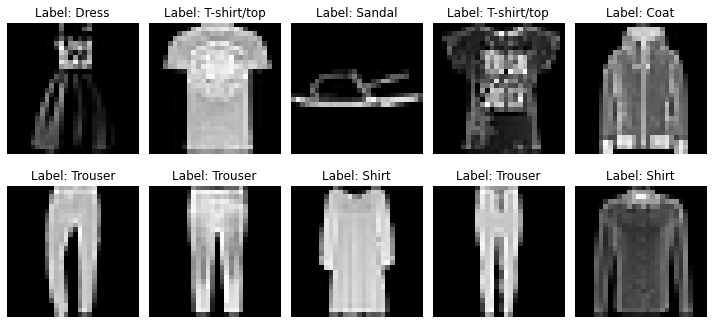

In [9]:
random_idxs = np.random.choice(X_train.shape[0], 10, replace=False) # Randomly Sample Images
fig, ax = plt.subplots(2, 5, figsize=(10, 5), tight_layout=True)

for idx, subplot in zip(random_idxs, ax.ravel()):
  subplot.axis("off")
  subplot.imshow(X_train[idx], cmap='gray')
  subplot.set_title(f"Label: {class_labels[y_train[idx]]}")

Let's take a look at what each class looks like.

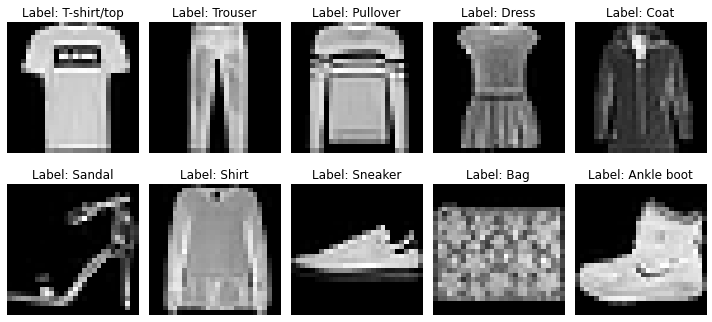

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5), tight_layout=True)
ax = ax.ravel()
for i in range(10):
  images = X_train[np.squeeze(y_train == i)][0]
  label = class_labels[i]
  subplot = ax[i]
  subplot.axis("off")
  subplot.imshow(images, cmap="gray")
  subplot.set_title(f"Label: {label}")

Now, let's visualize a larger subset of the data, to gain an idea as to how varied the data is.

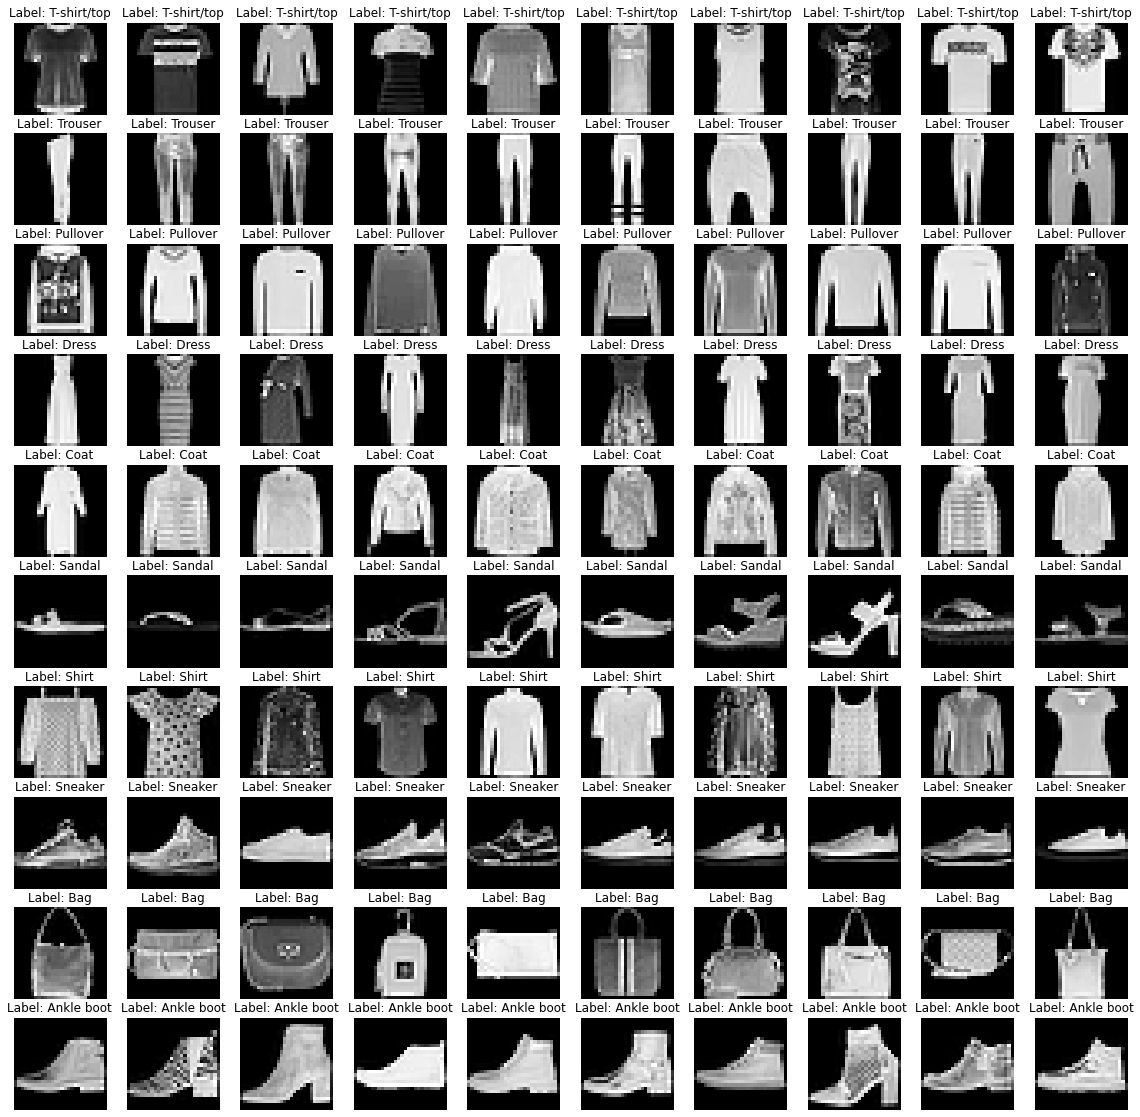

In [11]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
  images = X_train[np.squeeze(y_train == i)]
  random_idxs = np.random.choice(images.shape[0], 10, replace=False)
  images = images[random_idxs]
  label = class_labels[i]
  for j in range(10):
    subplot = ax[i, j]
    subplot.axis("off")
    subplot.imshow(images[j], cmap="gray")
    subplot.set_title(f"Label: {label}")
fig.show()
    

There are a few things that come to mind here
- Zalando is very consistent in the orientation of the images. The shoes always seem to have their tip pointing to the left for example.
- This does suggest room for augmenting their data via performing random flips
- The images are always zoomed in to about the same extent. So most fashion articles take up about the same size on the image

### Visualization of the Class Distribution
When training a machine learning model, it is always important to check the distribution of classes in the dataset. This informs us on what metrics would be best to use, and if anything needs to be done to detect imbalanced classes.

In [12]:
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
  print(f"{class_labels[label]}: {count}")

T-shirt/top: 4764
Trouser: 4794
Pullover: 4768
Dress: 4796
Coat: 4785
Sandal: 4806
Shirt: 4851
Sneaker: 4820
Bag: 4820
Ankle boot: 4796


<BarContainer object of 10 artists>

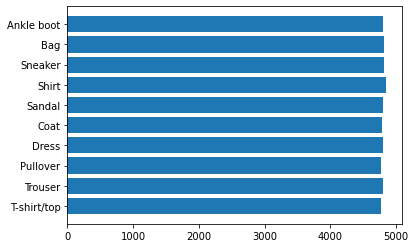

In [13]:
plt.barh(labels, counts, tick_label=list(class_labels.values()))

We can see that there is an even class balance. This means that we can make use of accuracy as our primary metric.

#### What does the distribution  of the images look like?
Another key statistic I would like to know is the distribution of the pixel intensities. 

In [14]:
print("Max:", np.max(X_train))
print("Min:", np.min(X_train))

Max: 255
Min: 0


As expected, our pixels have values between 0 and 255

In [15]:
mean, std = np.mean(X_train), np.std(X_train)
print("Mean:", mean)
print("std:", std)

Mean: 72.80250212585034
std: 89.97115739980539


From the mean pixel value, we see that the average pixel is not very bright, but there is some significant variation in the pixel intensities

#### What is the "average" image?

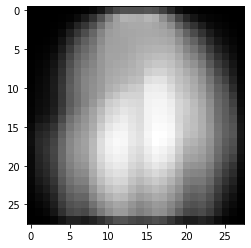

In [16]:
plt.imshow(np.mean(X_train, axis=0) / 255, cmap="gray")

We see that although it's not very clear, we can actually make out a shoe, pants and a shirt in the average image.

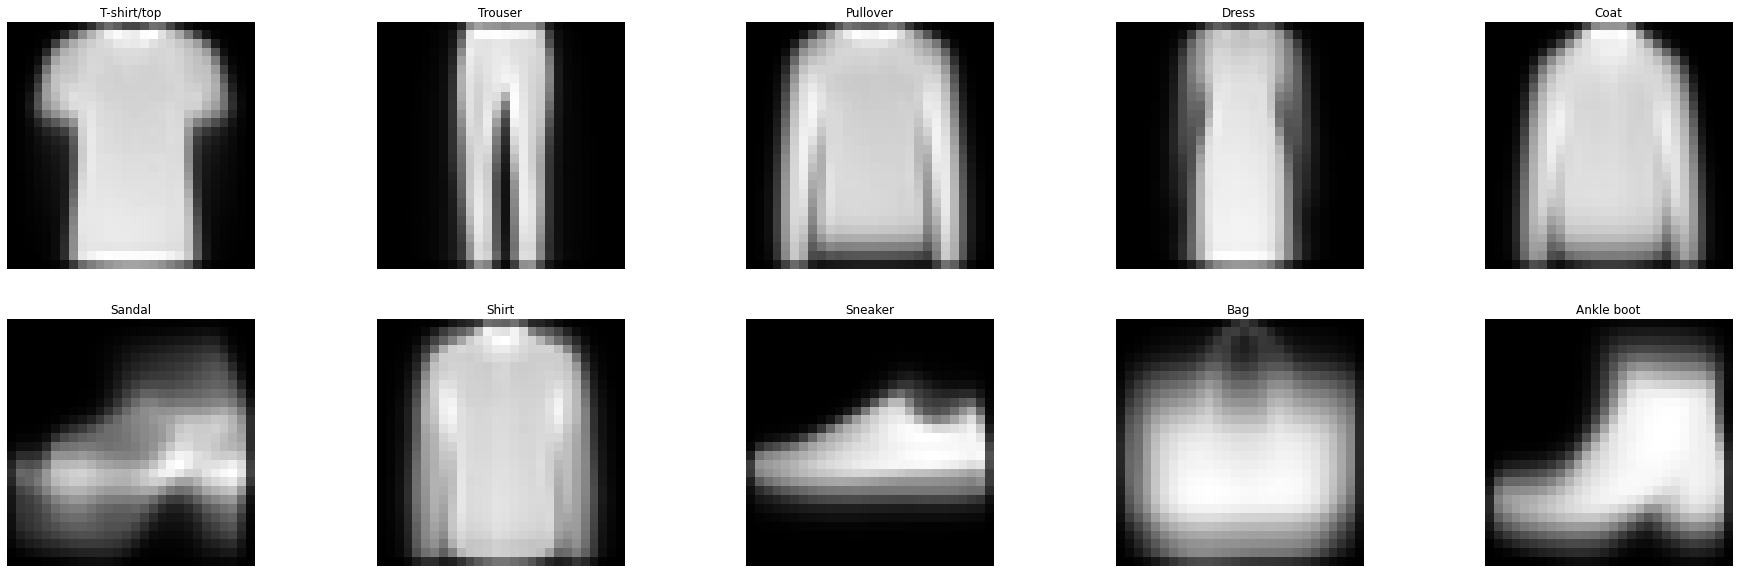

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(32, 10))

for idx, subplot in enumerate(ax.ravel()):
  avg_image = np.mean(X_train[np.squeeze(y_train == idx)], axis=0) / 255
  subplot.imshow(avg_image, cmap="gray")
  subplot.set_title(f"{class_labels[idx]}")
  subplot.axis("off")

When doing a class wise average, it is quite clear that most images of the same class are fairly similar to one another, as the averaged image is clearly recognizable for each class. 

## Basic Data Preprocessing
Before modelling, its important to perform data preprocessing.

### Encoding the Target Labels
As they are, the current labels are encoded from 0-9. I will need to one hot encode the labels. 

In [18]:
y_train = to_categorical(y_train) # one hot encode
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [19]:
print(y_train[0])
print("Label:", tf.argmax(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Label: tf.Tensor(9, shape=(), dtype=int64)


### Normalizing the Inputs
Image normalization is done to the dataset.

Normalizing the inputs means that we will calculate the mean and standard deviation of the training set, and then apply the formula below

$$
X_{} = \frac{X_{} - μ_{}}{σ_{}}
$$

When I do this, I help ensure that pixel values for each pixel are on a similar scale. This helps the optimization algorithm to better converge during gradient descent.

In [20]:
pre_processing_v1 = Normalization()
pre_processing_v1.adapt(X_train) # Calculate the mean and std of the train set

In [21]:
pre_processing_v1.mean

<tf.Tensor: shape=(1, 1, 28), dtype=float32, numpy=
array([[[  2.8499734,   8.859591 ,  12.368395 ,  20.10678  ,
          36.203266 ,  53.429104 ,  64.09722  ,  71.28215  ,
          84.05552  , 100.16229  , 113.58216  , 119.21431  ,
         121.25406  , 117.447205 , 115.07686  , 123.79108  ,
         127.0856   , 124.27342  , 116.62026  , 101.4611   ,
          87.20446  ,  80.27911  ,  73.2667   ,  59.864285 ,
          43.230743 ,  32.446007 ,  23.313972 ,   5.6430893]]],
      dtype=float32)>

In [22]:
pre_processing_v1.variance

<tf.Tensor: shape=(1, 1, 28), dtype=float32, numpy=
array([[[ 288.0153 , 1392.1926 , 1887.0803 , 2914.9216 , 4850.9116 ,
         6858.577  , 7760.283  , 7918.106  , 8247.954  , 8332.75   ,
         8158.617  , 7963.1963 , 8016.325  , 8044.842  , 8130.704  ,
         7922.196  , 7676.797  , 7676.688  , 8003.404  , 8299.23   ,
         8450.069  , 8588.875  , 8359.848  , 7256.945  , 5751.3223 ,
         4798.869  , 3700.376  ,  549.91345]]], dtype=float32)>

We see that values closer to the middle of the image have a higher mean and variance

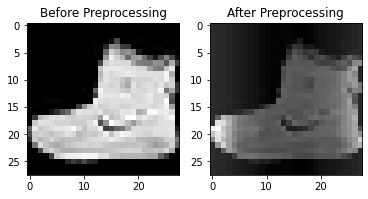

In [23]:
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(X_train[0], cmap='gray')
ax[0].set_title('Before Preprocessing')
ax[1].imshow(tf.squeeze(pre_processing_v1(X_train[:1, :, :])), cmap='gray')
ax[1].set_title('After Preprocessing')
fig.show()

### Basic Data Augmentation
Since our goal is to prevent overfitting, we also apply data augmentation. Data augmentation is a method to reduce the variance of a model by imposing random transformations on the data during training. For data augmentation, I start off with more basic data augmentations: random flips and crops

I specify the batch size as 128. 128 was chosen as I wanted a small batch size, since small batch sizes have a regularizing effect on the network.

In [24]:
BATCH_SIZE = 128 #@param {type:"number"}

In [25]:
def basic_data_aug(images):
 image = random_flip_left_right(images) 
 image = resize_with_crop_or_pad(image, IMG_SIZE[0] + 4, IMG_SIZE[1] + 4)
 image = random_crop(
     image, size=IMG_SIZE
 )
 return image

no_data_aug = lambda x : x

In [26]:
def set_up_data_aug(aug_func=basic_data_aug):
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(lambda x, y : (expand_dims(x, -1), y))
  val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).map(lambda x, y : (expand_dims(x, -1), y)).prefetch(tf.data.AUTOTUNE)
  train_ds = train_ds.map(
      lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE
  ).shuffle(BATCH_SIZE * 100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return train_ds, val_ds

In [27]:
train_ds, val_ds = set_up_data_aug(no_data_aug)
train_aug_ds, val_ds = set_up_data_aug()

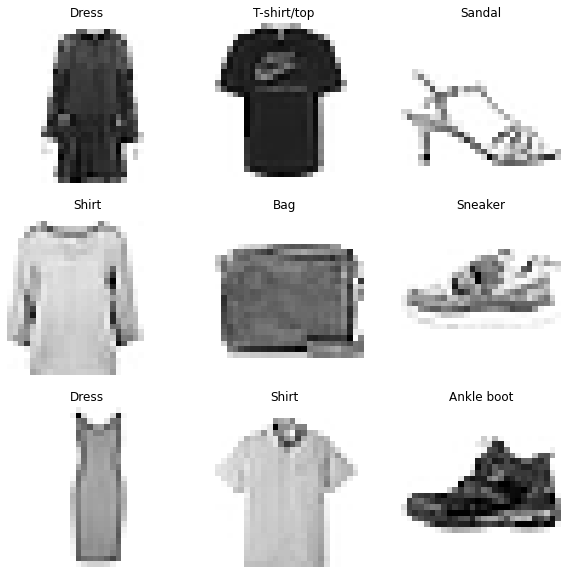

In [28]:
image_batch, label_batch = next(iter(train_aug_ds))
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for idx, subplot in enumerate(ax.ravel()):
  subplot.set_title(class_labels[np.argmax(label_batch[idx])])
  subplot.imshow(tf.squeeze(image_batch[idx]), cmap="Greys")
  subplot.axis("off")


## Modelling
Once we've set up a pre-processing pipeline, we will begin training various models.



### Optimization Algorithm
For all models, we will train them using stochastic gradient descent (with Momentum). This choice was made as SGD seems to generalize better on tasks like image classification (see [Arxiv: Towards Theoretically Understanding Why SGD Generalizes Better Than ADAM in Deep Learning](https://arxiv.org/abs/2010.05627)), as compared to other optimizers like Adam. Since our primary focus is on building a robust model, it makes sense to use the SGD optimizer.

For learning rate scheduling, I begin by adopting a basic learning rate scheduler, which is to use a a callback to Reduce the Learning Rate when the validation loss plateaus.


### Training
- I make use of Early Stopping to stop model training once it begins to overfit



### Experiment Logger
To make the process of model training more standardized, I have created a class which will keep track of the various Models tested during the notebook. I also set some basic hyperparameters: a learning rate of 0.01, momentum set to 0.9, number of epochs set to 100

`steps_per_epoch` is set later to determine the decay rate when I test out learning rate schedules.

In [29]:
#@title Base Hyperparameters
LR = 0.01 #@param {type:"number"}
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
VAL_SPLIT = 0.2 #@param {type:"number"}
MAX_EPOCHS = 100 #@param {type:"integer"}
base_hparams = {
    "val_split" : VAL_SPLIT,
    "max_epochs" : MAX_EPOCHS,
    "batch_size" : BATCH_SIZE
}

steps_per_epoch = np.ceil(len(X_train) / BATCH_SIZE)
# scheduler = CosineDecay(LR, steps_per_epoch * 50)

In [30]:
def plot_loss_curve(model_history):
  model_history = pd.DataFrame(model_history)
  epochs = list(range(1, len(model_history) + 1))
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=epochs, y=model_history["loss"],
                    mode='lines+markers',
                    name='Training Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_loss"],
                    mode='lines+markers',
                    name='Validation Loss'))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["accuracy"],
                    mode="lines+markers",
                    name="Training Accuracy"))
  fig.add_trace(go.Scatter(x=epochs, y=model_history["val_accuracy"],
                           mode="lines+markers",
                           name="Validation Accuracy"))
  fig.update_layout(
    title="Loss/Acc Plot",
    xaxis_title="Epochs",
    yaxis_title="Loss/Acc",
)

  return fig

In [31]:
class ModelEvaluator:
  """
  A class to keep track of experiments made, so that it is easier to keep track of experimentation
  """
  def __init__(self, history_path = None, base_savedir = "/content/drive/MyDrive/Data/DELE CA1/Fashion MNIST"):
    if history_path is None:
      self.result_history = pd.DataFrame({
          "Model Name" : [],
          "Epochs" : [],
          "Batch Size" : [],
          "Train Loss" : [],
          "Test Loss" : [],
          "Train Acc" : [],
          "Test Acc" : [],
          "Remarks" : [],
          "Model Path" : []
      })
    else:
      self.result_history = pd.read_csv(history_path, sep=";")
    self.default_callbacks = [
                                  TerminateOnNaN(),
                                  CSVLogger("/tmp/training.log", append=False)
    ]
    self.base_savedir = base_savedir
  def evaluate_model(self, model, training_data , validation_data, hyperparameters =base_hparams, callbacks = None, plot_loss = True, remarks = "", savedir = None):
    """
    Evaluate a model. Assumes the model has already been compiled, so compilation and choice of optimizer must be done beforehand
    """
    # Train Model
    tf.keras.backend.clear_session() # clear all previous models from memory
    if callbacks is None:
      callbacks = [EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5)]
    callbacks = self.default_callbacks + callbacks
    name = model.name
    validation_split = hyperparameters["val_split"]
    epochs = hyperparameters["max_epochs"]
    batch_size = hyperparameters["batch_size"]
    if savedir is None:
      filepath = f"{self.base_savedir}/SavedModels/{name}"
    else:
      filepath = savedir
    print(f"Training {name}")
    # modelcheck = ModelCheckpoint(
    #     filepath,
    #     save_best_only = True,
    #     monitor = "val_accuracy",
    #     verbose = 0,
    # )
    # callbacks += [modelcheck]
    try:
      if validation_data is None:
        X_train, y_train = training_data
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,callbacks=callbacks)
      else:
        history = model.fit(training_data, validation_data=validation_data, epochs=epochs, batch_size=batch_size,callbacks=callbacks)
      history = history.history
      # print(history)
    except KeyboardInterrupt:
      history = pd.read_csv("/tmp/training.log")
      # print(history)
      print("\nHalting Training")
    print(f"Saving best model to {filepath}")
    model.save(filepath)
    if plot_loss:
      try:
        fig = plot_loss_curve(history)
      except:
        print("error creating loss curve")
        fig = None
    else:
      fig = None
    result = dict()
    result["Epochs"] = len(history["loss"])
    result["Batch Size"] = batch_size
    result["Model Name"] = name
    result["Remarks"] = remarks
    result["Model Path"] = filepath
    # Calculate Statistics
    best_val_idx = np.argmax(history["val_accuracy"])
    result["Train Loss"] = history["loss"][best_val_idx]
    result["Test Loss"] = history["val_loss"][best_val_idx]
    result["Train Acc"] = history["accuracy"][best_val_idx]
    result["Test Acc"] = history["val_accuracy"][best_val_idx]
    result["[Train - Test] Acc"] = result["Train Acc"] - result["Test Acc"]
    self.result_history = self.result_history.append(result, ignore_index=True)
    tf.keras.backend.clear_session() # clear all previous models from memory
    return pd.Series(result), fig
  def return_model(self, model_name):
    filepath = self.result_history[
                                   self.result_history["Model Name"] == model_name
    ]["Model Path"]
    assert len(filepath) == 1, "There is no model or more than one model with that name!"
    filepath = filepath.values[0]
    model = tf.keras.models.load_model(filepath)
    return model

  def return_history(self, include_cols = ['Model Name', 'Train Acc', 'Test Acc', '[Train - Test] Acc', 'Remarks'] ):
    return self.result_history[include_cols]

  # def return_training_logs(self, model_name):
  #   raise NotImplementedError

  # def return_loss_plot(self, model_name):
  #   raise NotImplementedError
  #   logs = return_training_logs(model_name)
  #   return plot_loss_curve(logs)
  def remove_model(self, model_name):
    mask = ~(self.result_history["Model Name"] == model_name)
    self.result_history = self.result_history[mask]
  def add_remarks(self, model_name, comment):
    """
    Add comments to a model result
    Comments can include:
      - Sources of Error
      - Notes about model architecture
    """
    mask = (self.result_history["Model Name"] == model_name)
    assert mask.sum() == 1, "There is no model or more than one model with that name!"
    self.result_history.loc[mask, "Remarks"] = comment

  def save_history(self, file_name = None):
    if file_name is None:
      file_name = f"{self.base_savedir}/history.csv"
    self.result_history.to_csv(file_name, sep=";", index=False)
    print(f"History saved to {file_name}")

In [32]:
evaluator = ModelEvaluator("/content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/history.csv")
# evaluator = ModelEvaluator()

In [33]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Deep_ANN_1,0.910812,0.879917,0.030896,Overfitting
1,Deep_ANN_1_DataAug,0.876979,0.848417,0.028562,Worse performance overall
2,Deep_ANN_Regularized_1,0.903771,0.879000,0.024771,NaN
3,VGGNet,0.999979,0.934500,0.065479,NaN
4,VGGNet_BasicDataAug,0.952458,0.918833,0.033625,NaN
5,VGGNet_CutMix,0.881771,0.946167,-0.064396,NaN
6,PNet,0.913646,0.904250,0.009396,NaN
7,PNet_Cutmix,0.830458,0.923833,-0.093375,NaN
8,PNet_Adam_CutMix,0.856229,0.936083,-0.079854,NaN
9,PNet_DataAug_Fixed,0.926000,0.902250,0.023750,NaN


In [34]:
assert 1 == 2, "Stop Execution Beyond This Point"

AssertionError: ignored

### Baseline Fully Connected Neural Network
As our initial baseline, I choose to build a fully connected neural network with three hidden layers. 

In [ ]:
def build_deep_network(optimizer=optimizer, name='Deep_ANN_1'):
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs)
  x = Flatten()(x)
  x = Dense(128, 'relu')(x) # Hidden Layer 1
  x = Dense(128, 'relu')(x) # Hidden Layer 3
  x = Dense(128, 'relu')(x) # Hidden Layer 3
  x = Dense(10, 'softmax')(x)
  model = Model(inputs=inputs, outputs=x, name=name)
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_deep_network(optimizer)

Model: "Deep_ANN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 flatten (Flatten)           (None, 21952)             0         
                                                                 
 dense (Dense)               (None, 128)               2809984   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                        

#### Without Data Aug
I first try training the network without any data augmentation.

In [ ]:
train_ds, val_ds = set_up_data_aug(no_data_aug)

In [ ]:
results, fig = evaluator.evaluate_model(model, train_ds, val_ds)

Training Deep_ANN_1
Epoch 1/100
375/375 [==============================] - 4s 7ms/step - loss: 0.8281 - accuracy: 0.7560 - val_loss: 0.4668 - val_accuracy: 0.8295 - lr: 0.0100
Epoch 2/100
375/375 [==============================] - 3s 6ms/step - loss: 0.4403 - accuracy: 0.8391 - val_loss: 0.4513 - val_accuracy: 0.8297 - lr: 0.0100
Epoch 3/100
375/375 [==============================] - 3s 6ms/step - loss: 0.4068 - accuracy: 0.8521 - val_loss: 0.4112 - val_accuracy: 0.8427 - lr: 0.0100
Epoch 4/100
375/375 [==============================] - 3s 6ms/step - loss: 0.3932 - accuracy: 0.8554 - val_loss: 0.4233 - val_accuracy: 0.8474 - lr: 0.0100
Epoch 5/100
375/375 [==============================] - 3s 6ms/step - loss: 0.3735 - accuracy: 0.8612 - val_loss: 0.4240 - val_accuracy: 0.8487 - lr: 0.0100
Epoch 6/100
375/375 [==============================] - 3s 6ms/step - loss: 0.3591 - accuracy: 0.8675 - val_loss: 0.3864 - val_accuracy: 0.8594 - lr: 0.0100
Epoch 7/100
375/375 [=======================

In [ ]:
display(results)
fig.show()

Epochs                                                               35
Batch Size                                                          128
Model Name                                                   Deep_ANN_1
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                     0.233721
Test Loss                                                      0.351674
Train Acc                                                      0.910812
Test Acc                                                       0.879917
[Train - Test] Acc                                            0.0308958
dtype: object

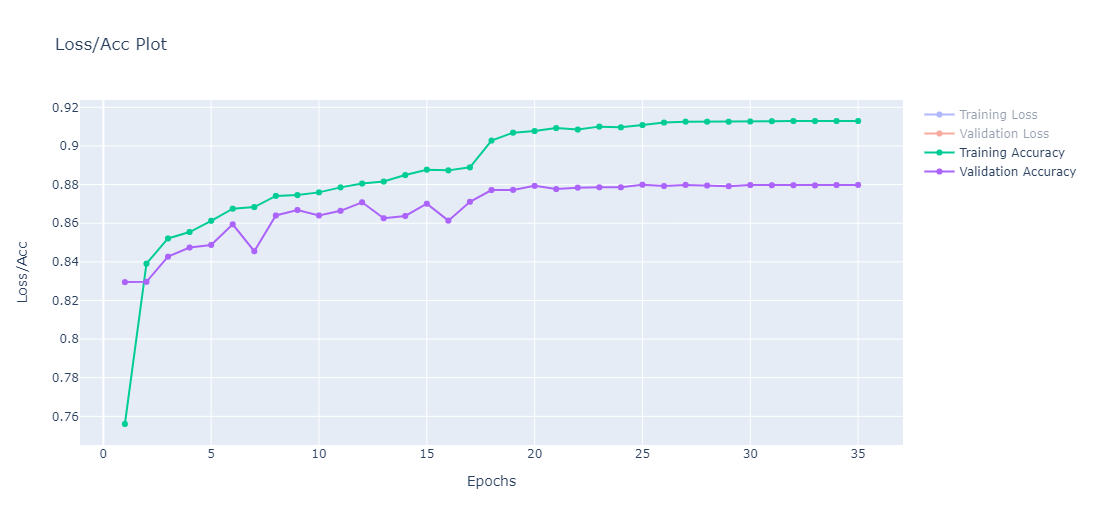

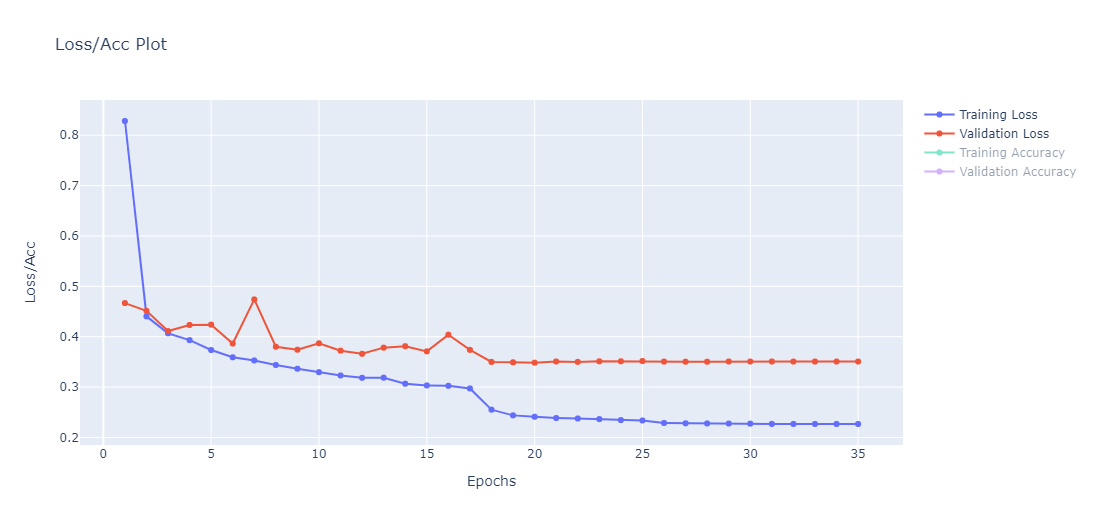

From the loss curve , I can see that the model begins to overfit after epoch 17. The final validation accuracy is approximately 0.88 (rounding up).

So, I can see that the baseline is strong, but suffers from overfitting.

In [ ]:
evaluator.add_remarks("Deep_ANN_1", "Overfitting")
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/history.csv


#### With Data Aug
To try and reduce overfitting, I start by trying to make use of the basic data augmentation technique to improve model performance.

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_deep_network(name="Deep_ANN_1_DataAug", optimizer=optimizer)

Model: "Deep_ANN_1_DataAug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 flatten (Flatten)           (None, 21952)             0         
                                                                 
 dense (Dense)               (None, 128)               2809984   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                

In [ ]:
train_aug_ds, val_ds = set_up_data_aug()

In [ ]:
results, fig = evaluator.evaluate_model(model, train_aug_ds, val_ds)

Training Deep_ANN_1_DataAug
Epoch 1/100
375/375 [==============================] - 6s 11ms/step - loss: 1.0895 - accuracy: 0.6458 - val_loss: 0.7025 - val_accuracy: 0.7126 - lr: 0.0100
Epoch 2/100
375/375 [==============================] - 5s 11ms/step - loss: 0.6845 - accuracy: 0.7404 - val_loss: 0.6023 - val_accuracy: 0.7791 - lr: 0.0100
Epoch 3/100
375/375 [==============================] - 5s 11ms/step - loss: 0.6296 - accuracy: 0.7609 - val_loss: 0.5950 - val_accuracy: 0.7832 - lr: 0.0100
Epoch 4/100
375/375 [==============================] - 5s 11ms/step - loss: 0.6007 - accuracy: 0.7753 - val_loss: 0.6201 - val_accuracy: 0.7755 - lr: 0.0100
Epoch 5/100
375/375 [==============================] - 5s 11ms/step - loss: 0.5704 - accuracy: 0.7857 - val_loss: 0.5164 - val_accuracy: 0.8110 - lr: 0.0100
Epoch 6/100
375/375 [==============================] - 5s 11ms/step - loss: 0.5566 - accuracy: 0.7924 - val_loss: 0.5526 - val_accuracy: 0.7978 - lr: 0.0100
Epoch 7/100
375/375 [=========

In [ ]:
display(results)
fig.show()

Epochs                                                               46
Batch Size                                                          128
Model Name                                           Deep_ANN_1_DataAug
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                     0.327928
Test Loss                                                      0.435489
Train Acc                                                      0.876979
Test Acc                                                       0.848417
[Train - Test] Acc                                            0.0285625
dtype: object

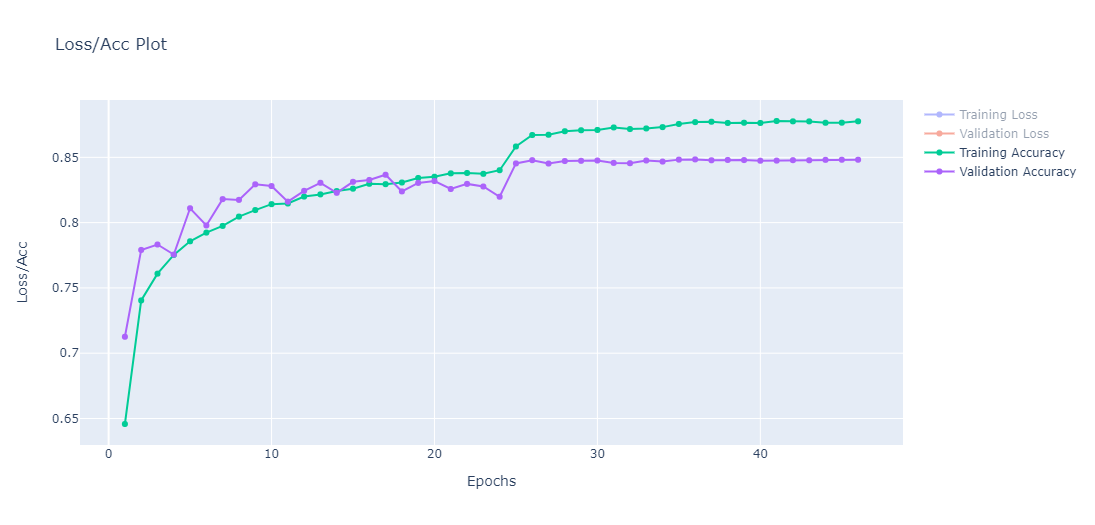

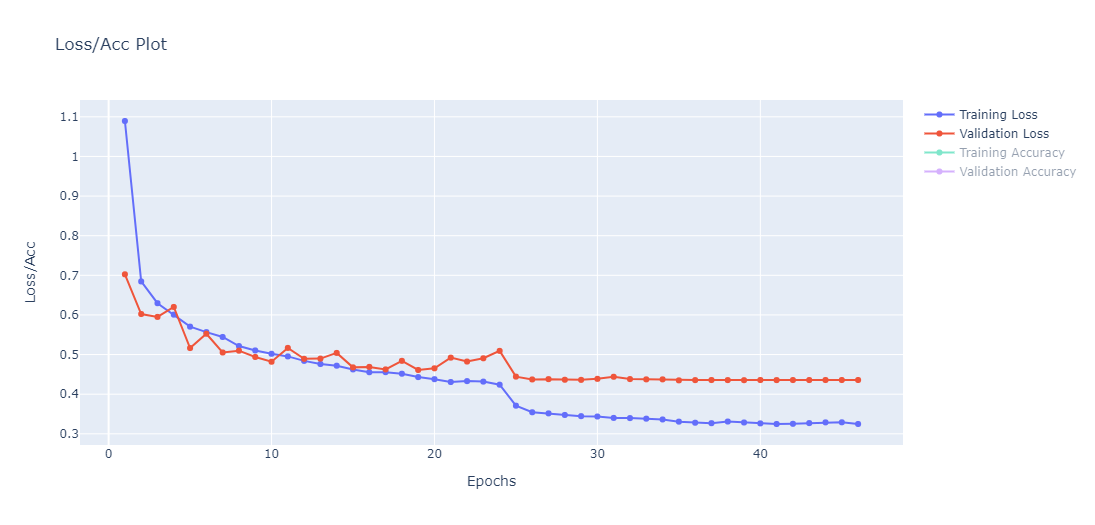

From the final best validation and training score, I can see that while the data augmentation does reduce overfitting slightly, it comes at the cost of overall accuracy (both training and validation)



In [ ]:
evaluator.add_remarks("Deep_ANN_1_DataAug", "Worse performance overall")
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/history.csv


In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Deep_ANN_1,0.910812,0.879917,0.030896,Overfitting
1,Deep_ANN_1_DataAug,0.876979,0.848417,0.028562,Worse performance overall


#### With Regularization
Instead of applying data augmentation, I try just introducing some weight decay (L2 Regularization) to reduce the variance of the model.

In [ ]:
def build_deep_network_regularized(optimizer=optimizer, name='Deep_ANN_Regularized_1'):
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs)
  x = Flatten()(x)
  x = Dense(128, 'relu', kernel_regularizer=l2(WEIGHT_DECAY))(x) # Hidden Layer 1
  x = Dense(128, 'relu', kernel_regularizer=l2(WEIGHT_DECAY))(x) # Hidden Layer 3
  x = Dense(128, 'relu', kernel_regularizer=l2(WEIGHT_DECAY))(x) # Hidden Layer 3
  x = Dense(10, 'softmax', kernel_regularizer=l2(WEIGHT_DECAY))(x)
  model = Model(inputs=inputs, outputs=x, name=name)
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_deep_network_regularized(optimizer)

Model: "Deep_ANN_Regularized_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 flatten (Flatten)           (None, 21952)             0         
                                                                 
 dense (Dense)               (None, 128)               2809984   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                            

In [ ]:
train_ds, val_ds = set_up_data_aug(no_data_aug)

In [ ]:
results, fig = evaluator.evaluate_model(model, train_ds, val_ds)
display(results)
fig.show()

Training Deep_ANN_Regularized_1
Epoch 1/100
375/375 [==============================] - 3s 7ms/step - loss: 1.0843 - accuracy: 0.7678 - val_loss: 0.8207 - val_accuracy: 0.8217 - lr: 0.0100
Epoch 2/100
375/375 [==============================] - 3s 7ms/step - loss: 0.7418 - accuracy: 0.8430 - val_loss: 0.7075 - val_accuracy: 0.8518 - lr: 0.0100
Epoch 3/100
375/375 [==============================] - 3s 7ms/step - loss: 0.6857 - accuracy: 0.8559 - val_loss: 0.6900 - val_accuracy: 0.8571 - lr: 0.0100
Epoch 4/100
375/375 [==============================] - 3s 7ms/step - loss: 0.6467 - accuracy: 0.8628 - val_loss: 0.6994 - val_accuracy: 0.8465 - lr: 0.0100
Epoch 5/100
375/375 [==============================] - 3s 7ms/step - loss: 0.6183 - accuracy: 0.8678 - val_loss: 0.6547 - val_accuracy: 0.8553 - lr: 0.0100
Epoch 6/100
375/375 [==============================] - 3s 7ms/step - loss: 0.5930 - accuracy: 0.8717 - val_loss: 0.5998 - val_accuracy: 0.8705 - lr: 0.0100
Epoch 7/100
375/375 [===========

Epochs                                                               39
Batch Size                                                          128
Model Name                                       Deep_ANN_Regularized_1
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                     0.347269
Test Loss                                                      0.438977
Train Acc                                                      0.903771
Test Acc                                                          0.879
[Train - Test] Acc                                            0.0247708
dtype: object

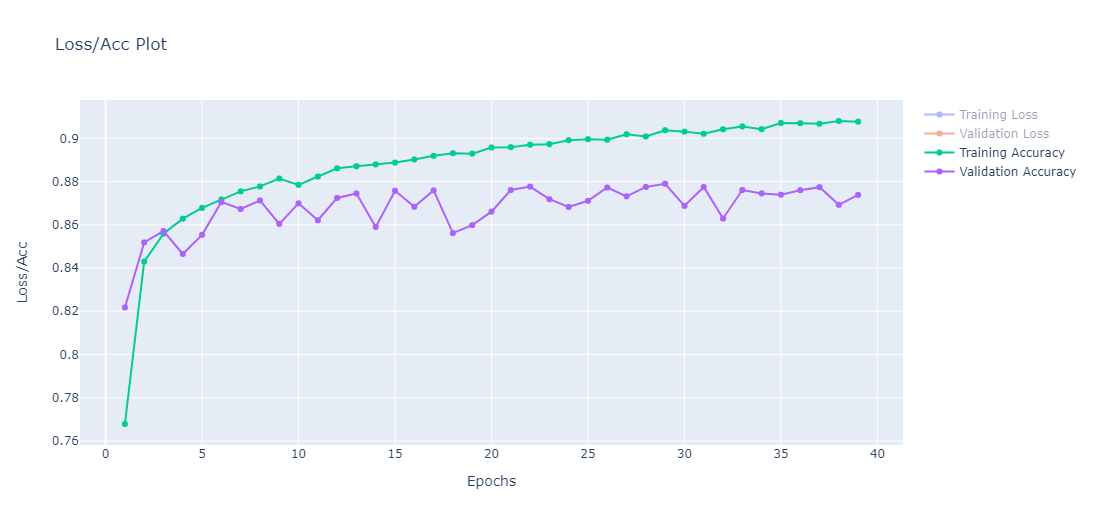

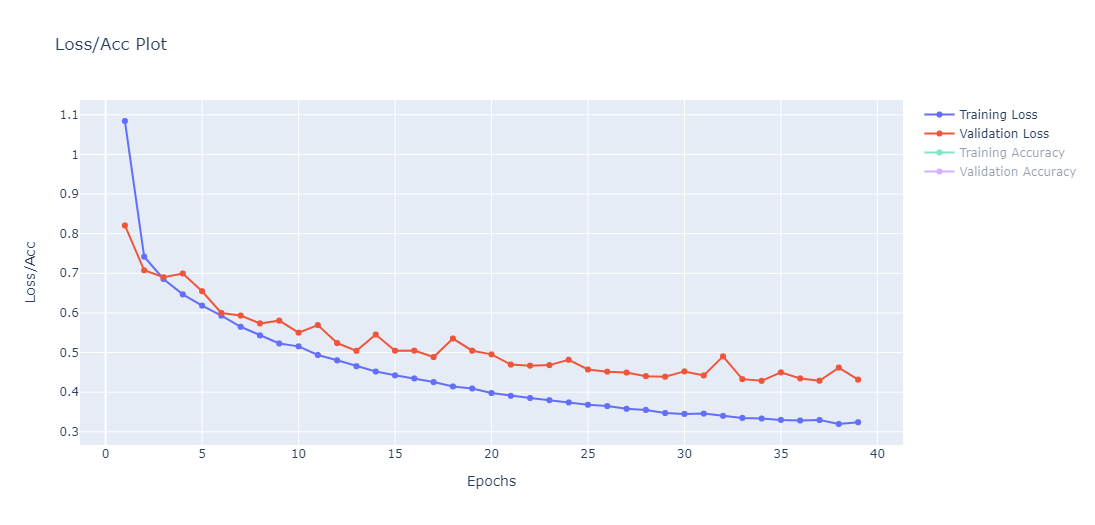

In [ ]:
evaluator.save_history()
evaluator.return_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/history.csv


,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Deep_ANN_1,0.910812,0.879917,0.030896,Overfitting
1,Deep_ANN_1_DataAug,0.876979,0.848417,0.028562,Worse performance overall
2,Deep_ANN_Regularized_1,0.903771,0.879000,0.024771,


Introducing basic regularization does reduce overfitting slightly, but otherwise makes no significant difference.

To do better, I decide to move towards a CNN architecture. The main reason why I want to move towards a CNN architecture is because CNNs are well suited to the problem of image classification
- They are parameter efficient due to the sparse connections and weight sharing

### Custom VGGNet Inspired Network (10 Conv)
To begin with, we will construct a simple CNN, loosely based off [VGGNet](https://arxiv.org/abs/1409.1556).

Instead of just wholesale taking the VGG architecture, I downsize it and make certain improvements. The reason I do so is 
- VGG architecture is rather old at this point, so I want to bring forward some improvements from other architecture, without making the network too complex
- VGG architecture has a lot of parameters (>100 million parameters), which I think I overkill for this particular problem

So, here's what I've done:
- I reduce the number of convolutional layers to 10. 
- Added Batch Normalization: BN has a regularizing effect on a CNN, by normalising inputs to layers deeper into a network)
- Number of Filters: the number of filters in each layer has been cut in half, to reduce the parameter count
- Global Pooling: While VGGNet flattened their output, global pooling is used instead of flattening the output, which helps to prevent overfitting. This change is taken from Network in Network.
- Dropout: Since I want to reduce overfitting, I add a dropout layer before the final clasification head
- L2 Regularization: To further reduce overfitting.

The end result is a much smaller network than the original VGG networks

My implementation is forked from that given in [Dive into Deep Learning](https://d2l.ai/chapter_convolutional-modern/vgg.html#)

In [39]:
class VGGConvLayer(Model):
  """
  Basic Conv Layer, with Batch Normalization done before activation
  """
  def __init__(self, filters , activation = ReLU):
    super(VGGConvLayer, self).__init__() # subclassing a layer
    self.layer_conv_1 = Conv2D(filters, (3, 3), padding='same', strides=1, kernel_regularizer=l2(WEIGHT_DECAY))
    self.layer_bn_1 = BatchNormalization()
    self.layer_activation_1 = activation()

  def call(self, X):
    X = self.layer_conv_1(X)
    X = self.layer_bn_1(X)
    return self.layer_activation_1(X)

In [40]:
class VGGConvBlock(Layer):
  def __init__(self, no_layers, filters, activation=ReLU):
    super(VGGConvBlock, self).__init__()
    self.conv_block = Sequential()
    for _ in range(no_layers):
      self.conv_block.add(
          VGGConvLayer(filters, activation=activation)
      )
    self.conv_block.add(MaxPool2D(strides=2))

  def call(self, X):
    return self.conv_block(X)

In [41]:
def build_vggnet(optimizer, name="VGGNet"):
  """
  A modified and cut down version of VGG16, using GlobalPooling, and a modified VGGBlock
  """
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs)
  x = VGGConvBlock(2, 32)(x) # compared to vgg, we use fewer filters
  x = VGGConvBlock(2, 64)(x)
  x = VGGConvBlock(3, 128)(x)
  x = VGGConvBlock(3, 256)(x)
  # Global Pooling
  x = GlobalAveragePooling2D()(x) 
  # Classification Head
  x = Dropout(0.3)(x)
  x = Dense(10, 'softmax')(x)
  model = Model(inputs=inputs, outputs=x, name=name)
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model

#### Without Data Augmentation
Since I've already done steps to reduce overfitting, I first try to not use data augmentation to see if it is necessary

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_vggnet(optimizer)

Model: "VGGNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 vgg_conv_block (VGGConvBloc  (None, 14, 14, 32)       17600     
 k)                                                              
                                                                 
 vgg_conv_block_1 (VGGConvBl  (None, 7, 7, 64)         55936     
 ock)                                                            
                                                                 
 vgg_conv_block_2 (VGGConvBl  (None, 3, 3, 128)        370560    
 ock)                                                       

In [ ]:
train_ds, val_ds = set_up_data_aug(no_data_aug)

In [ ]:
results, fig = evaluator.evaluate_model(model, train_ds, val_ds)

Training VGGNet
Epoch 1/100
375/375 [==============================] - 14s 14ms/step - loss: 1.0655 - accuracy: 0.8322 - val_loss: 0.9230 - val_accuracy: 0.8768 - lr: 0.0100
Epoch 2/100
375/375 [==============================] - 5s 14ms/step - loss: 0.8440 - accuracy: 0.8985 - val_loss: 0.8549 - val_accuracy: 0.8877 - lr: 0.0100
Epoch 3/100
375/375 [==============================] - 5s 14ms/step - loss: 0.7635 - accuracy: 0.9150 - val_loss: 0.8007 - val_accuracy: 0.8995 - lr: 0.0100
Epoch 4/100
375/375 [==============================] - 6s 14ms/step - loss: 0.7014 - accuracy: 0.9251 - val_loss: 0.7352 - val_accuracy: 0.9119 - lr: 0.0100
Epoch 5/100
375/375 [==============================] - 5s 13ms/step - loss: 0.6490 - accuracy: 0.9347 - val_loss: 0.7009 - val_accuracy: 0.9105 - lr: 0.0100
Epoch 6/100
375/375 [==============================] - 6s 14ms/step - loss: 0.6007 - accuracy: 0.9413 - val_loss: 0.6694 - val_accuracy: 0.9132 - lr: 0.0100
Epoch 7/100
375/375 [====================

In [ ]:
display(results)
fig.show()

Epochs                                                               43
Batch Size                                                          128
Model Name                                                       VGGNet
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                     0.193258
Test Loss                                                      0.538002
Train Acc                                                      0.999979
Test Acc                                                         0.9345
[Train - Test] Acc                                            0.0654792
dtype: object

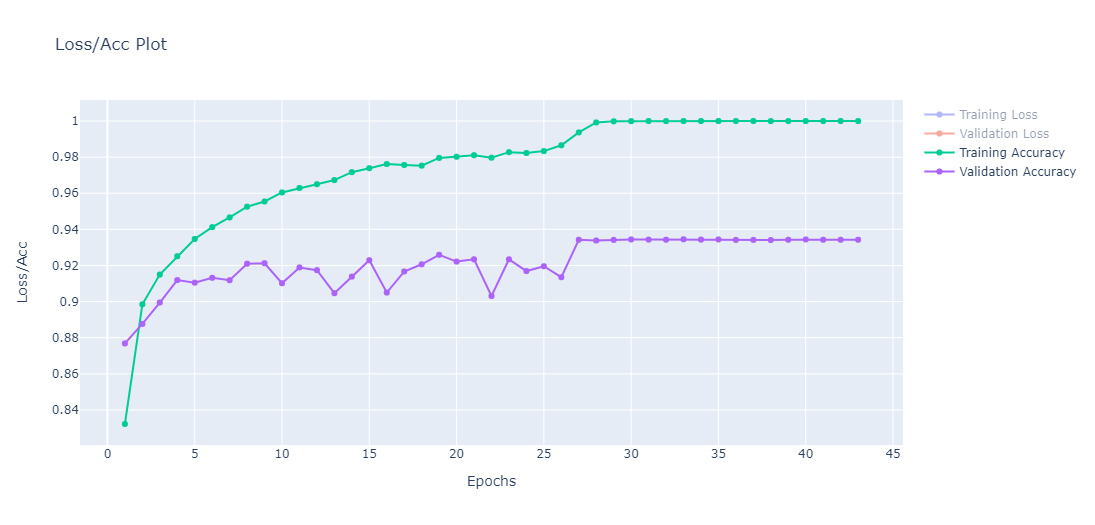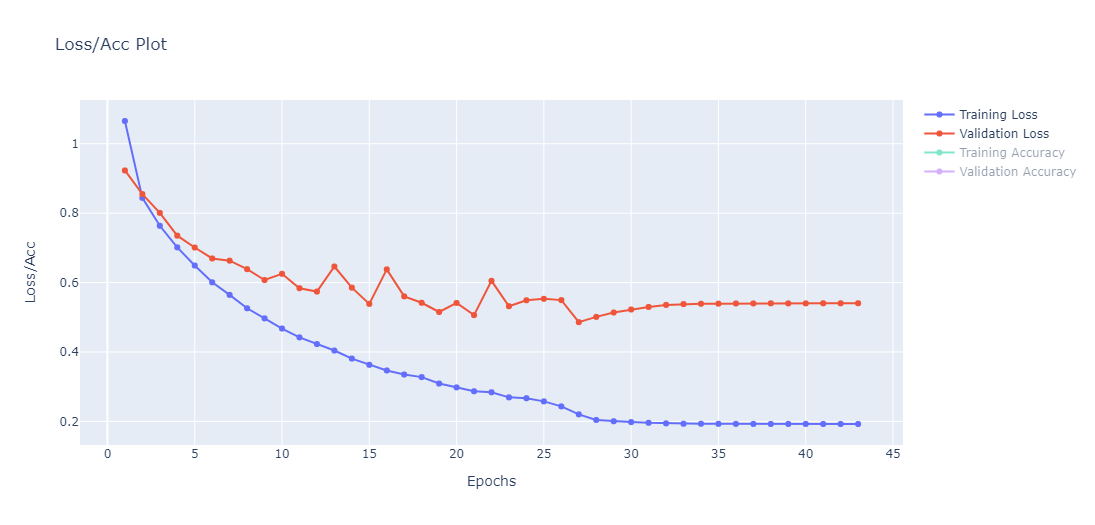

I observe that the model begins to overfit rather quickly, but converges quickly as well. The good news is that it does do better than the baseline (and has fewer parameters), but has worse overfitting. 

It would appear that data augmentation would be apt here. 

#### With Basic Data Augmentation

In [ ]:
train_aug_ds, val_ds = set_up_data_aug()

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_vggnet(optimizer, "VGGNet_BasicDataAug")
results, fig = evaluator.evaluate_model(model, train_aug_ds, val_ds)

Model: "VGGNet_BasicDataAug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 vgg_conv_block (VGGConvBloc  (None, 14, 14, 32)       17600     
 k)                                                              
                                                                 
 vgg_conv_block_1 (VGGConvBl  (None, 7, 7, 64)         55936     
 ock)                                                            
                                                                 
 vgg_conv_block_2 (VGGConvBl  (None, 3, 3, 128)        370560    
 ock)                                          

In [ ]:
display(results)
fig.show()

Epochs                                                               25
Batch Size                                                          128
Model Name                                          VGGNet_BasicDataAug
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                     0.420388
Test Loss                                                      0.523966
Train Acc                                                      0.952458
Test Acc                                                       0.918833
[Train - Test] Acc                                             0.033625
dtype: object

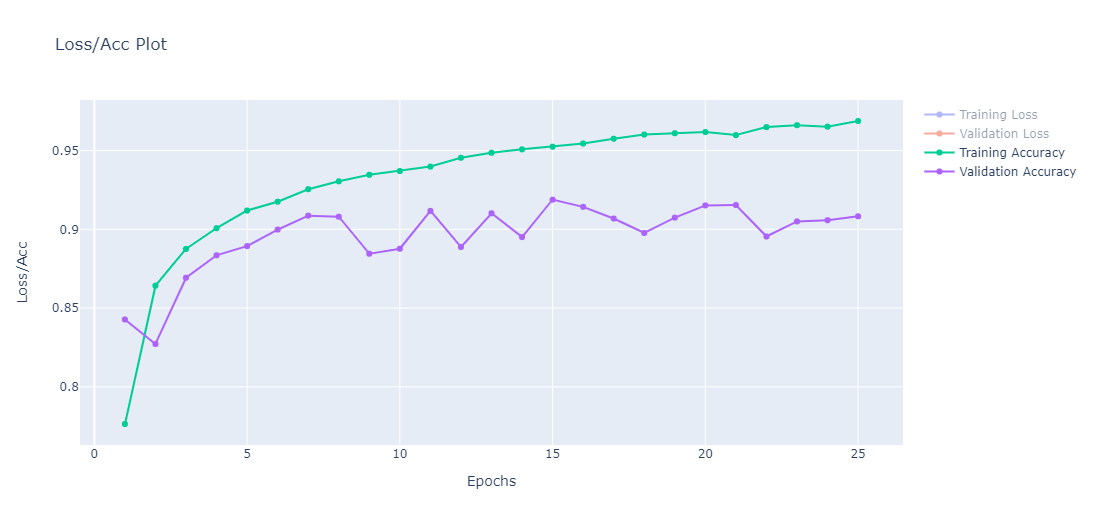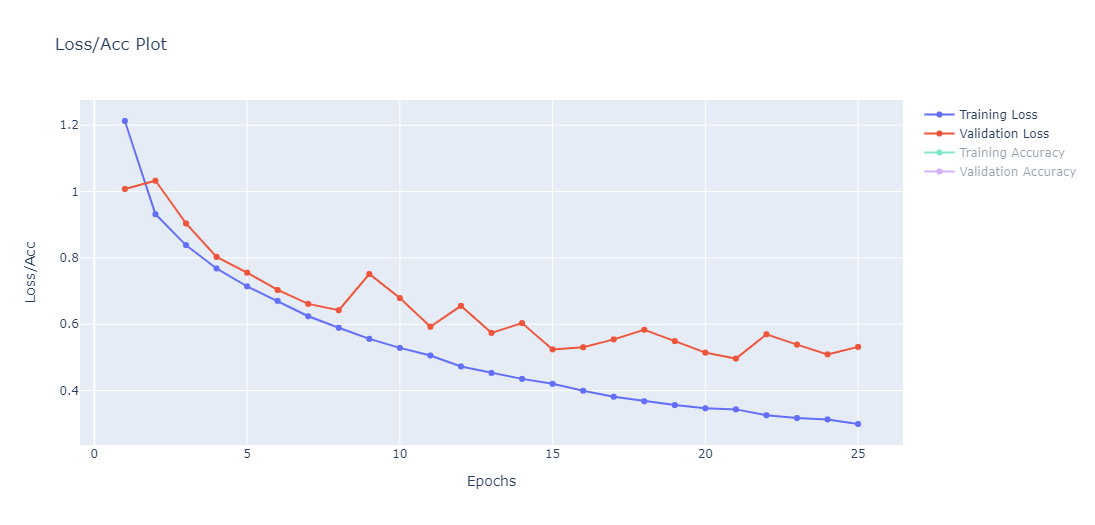

The basic data augmentation does manage to greatly reduce overfitting, but the validation accuracy decreases.

In [ ]:
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/history.csv


#### With CutMix Data Augmentation
From what was observed, it seems that even our basic data augmentation was not enough to prevent the network from greatly overfitting. So, I try out a data augmentation technique known as [CutMix](https://arxiv.org/abs/1905.04899v2), which is a much stronger form of data augmentation.

It works by cutting out portions of other images, and pasting them over another image. In additon, the label will be modified to reflect that the image contains two classes. This helps the model learn to identify an object from a partial view of it, improving generalization. 

Implementation adapted from: https://keras.io/examples/vision/cutmix/

In [35]:
def preprocess_data_v2(image, label):
  image = tf.expand_dims(image, -1)
  # image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

In [36]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
  gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
  gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
  return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
  cut_rat = tf.math.sqrt(1.0 - lambda_value)
  image_wh = IMG_SIZE[0]
  cut_wh = image_wh * cut_rat  # rw
  cut_wh = tf.cast(cut_wh, tf.int32)

  cut_x = tf.random.uniform((1,), minval=0, maxval=image_wh, dtype=tf.int32)  # rx
  cut_y = tf.random.uniform((1,), minval=0, maxval=image_wh, dtype=tf.int32)  # ry

  boundaryx1 = tf.clip_by_value(cut_x[0] - cut_wh // 2, 0, image_wh)
  boundaryy1 = tf.clip_by_value(cut_y[0] - cut_wh // 2, 0, image_wh)
  bbx2 = tf.clip_by_value(cut_x[0] + cut_wh // 2, 0, image_wh)
  bby2 = tf.clip_by_value(cut_y[0] + cut_wh // 2, 0, image_wh)

  target_h = bby2 - boundaryy1
  if target_h == 0:
      target_h += 1

  target_w = bbx2 - boundaryx1
  if target_w == 0:
      target_w += 1

  return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
  (image1, label1), (image2, label2) = train_ds_one, train_ds_two
  image_size = IMG_SIZE[0]
  alpha = [1]
  beta = [1]

  # Get a sample from the Beta distribution
  lambda_value = sample_beta_distribution(1, alpha, beta)

  # Define Lambda
  lambda_value = lambda_value[0][0]

  # Get the bounding box offsets, heights and widths
  boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

  # Get a patch from the second image (`image2`)
  crop2 = tf.image.crop_to_bounding_box(
      image2, boundaryy1, boundaryx1, target_h, target_w
  )
  # Pad the `image2` patch (`crop2`) with the same offset
  image2 = tf.image.pad_to_bounding_box(
      crop2, boundaryy1, boundaryx1, image_size, image_size
  )
  # Get a patch from the first image (`image1`)
  crop1 = tf.image.crop_to_bounding_box(
      image1, boundaryy1, boundaryx1, target_h, target_w
  )
  # Pad the `image1` patch (`crop1`) with the same offset
  img1 = tf.image.pad_to_bounding_box(
      crop1, boundaryy1, boundaryx1, image_size, image_size
  )

  # Modify the first image by subtracting the patch from `image1`
  # (before applying the `image2` patch)
  image1 = image1 - img1
  # Add the modified `image1` and `image2`  together to get the CutMix image
  image = image1 + image2

  # Adjust Lambda in accordance to the pixel ration
  lambda_value = 1 - (target_w * target_h) / (image_size * image_size)
  lambda_value = tf.cast(lambda_value, tf.float32)

  # Combine the labels of both images
  label = lambda_value * label1 + (1 - lambda_value) * label2
  return image, label

In [37]:
def set_up_cutmix():
  train_ds_one = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).map(preprocess_data_v2, num_parallel_calls=tf.data.AUTOTUNE)
  train_ds_two =  tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).map(preprocess_data_v2, num_parallel_calls=tf.data.AUTOTUNE)
  val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(2048).map(preprocess_data_v2, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two)) 
  train_ds_cutmix = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
  return train_ds_cutmix, val_ds


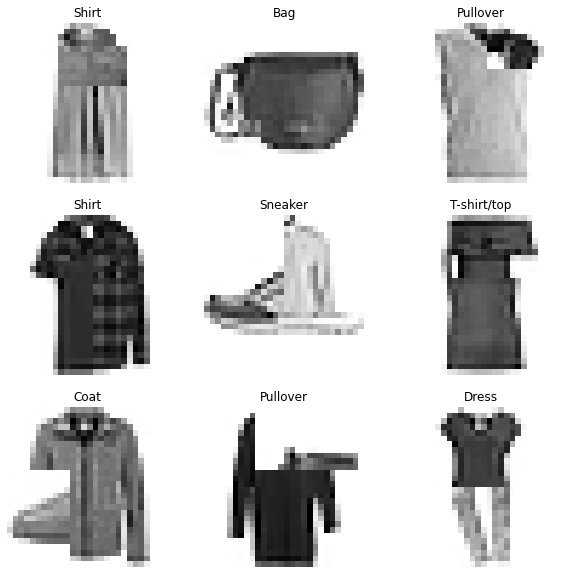

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()
image_batch, label_batch = next(iter(train_cutmix_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_labels[np.argmax(label_batch[i])])
    plt.imshow(tf.squeeze(image_batch[i]), cmap="Greys")
    plt.axis("off")

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_vggnet(optimizer, "VGGNet_CutMix")
results, fig = evaluator.evaluate_model(model, train_cutmix_ds, val_ds)

Model: "VGGNet_CutMix"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 vgg_conv_block (VGGConvBloc  (None, 14, 14, 32)       17600     
 k)                                                              
                                                                 
 vgg_conv_block_1 (VGGConvBl  (None, 7, 7, 64)         55936     
 ock)                                                            
                                                                 
 vgg_conv_block_2 (VGGConvBl  (None, 3, 3, 128)        370560    
 ock)                                                

In [ ]:
display(results)
fig.show()

Epochs                                                               56
Batch Size                                                          128
Model Name                                                VGGNet_CutMix
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                     0.814235
Test Loss                                                      0.309698
Train Acc                                                      0.881771
Test Acc                                                       0.946167
[Train - Test] Acc                                           -0.0643958
dtype: object

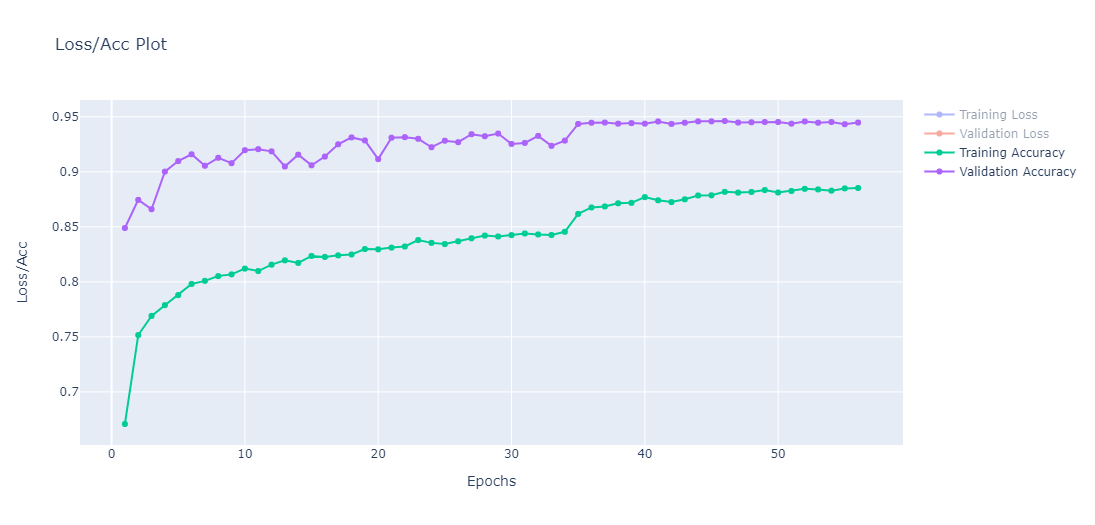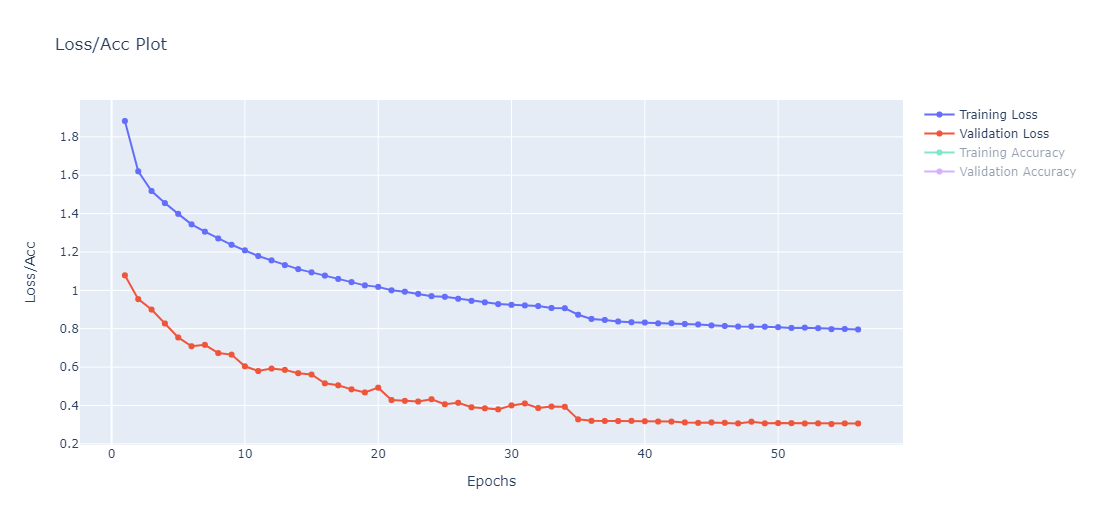

In this case, CutMix reverses our overfitting problem into an underfitting problem. Despite that, I do see the best performance thus far by using CutMix, suggesting that it would be good to continue using it.

In [ ]:
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/history.csv


In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Deep_ANN_1,0.910812,0.879917,0.030896,Overfitting
1,Deep_ANN_1_DataAug,0.876979,0.848417,0.028562,Worse performance overall
2,Deep_ANN_Regularized_1,0.903771,0.879000,0.024771,NaN
3,VGGNet,0.999979,0.934500,0.065479,NaN
4,VGGNet_BasicDataAug,0.952458,0.918833,0.033625,NaN
5,VGGNet_CutMix,0.881771,0.946167,-0.064396,NaN


#### Less Dropout and Modified Learning Rate Reduction
Hoping to counteract some of the underfitting, I try to reduce the dropout rate, and also play around with more aggressive reduction of learning rate during training.

In [ ]:
def build_custom_vgg_net(optimizer, name="Custom_VGGNet_LessDropout"):
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs)
  x = VGGConvBlock(2, 32)(x) 
  x = VGGConvBlock(2, 64)(x)
  x = VGGConvBlock(4, 128)(x)
  x = VGGConvBlock(4, 256)(x)
  # Global Pooling
  x = GlobalAveragePooling2D()(x) 
  # Classification Head
  x = Dropout(0.2)(x)
  x = Dense(10, 'softmax')(x)
  model = Model(inputs=inputs, outputs=x, name=name)
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_custom_vgg_net(optimizer)

Model: "Custom_VGGNet_LessDropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 vgg_conv_block (VGGConvBloc  (None, 14, 14, 32)       17600     
 k)                                                              
                                                                 
 vgg_conv_block_1 (VGGConvBl  (None, 7, 7, 64)         55936     
 ock)                                                            
                                                                 
 vgg_conv_block_2 (VGGConvBl  (None, 3, 3, 128)        518656    
 ock)                                    

In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5, factor=0.5, monitor="val_accuracy")]

In [ ]:
results, fig = evaluator.evaluate_model(model, train_cutmix_ds, val_ds, callbacks=callbacks)

Training Custom_VGGNet_LessDropout
Epoch 1/100
375/375 [==============================] - 16s 39ms/step - loss: 2.0781 - accuracy: 0.6685 - val_loss: 1.2827 - val_accuracy: 0.8473 - lr: 0.0100
Epoch 2/100
375/375 [==============================] - 15s 39ms/step - loss: 1.7948 - accuracy: 0.7482 - val_loss: 1.1097 - val_accuracy: 0.8886 - lr: 0.0100
Epoch 3/100
375/375 [==============================] - 15s 39ms/step - loss: 1.6857 - accuracy: 0.7691 - val_loss: 1.0036 - val_accuracy: 0.9051 - lr: 0.0100
Epoch 4/100
375/375 [==============================] - 15s 39ms/step - loss: 1.6062 - accuracy: 0.7821 - val_loss: 0.9814 - val_accuracy: 0.8966 - lr: 0.0100
Epoch 5/100
375/375 [==============================] - 15s 39ms/step - loss: 1.5378 - accuracy: 0.7902 - val_loss: 0.9210 - val_accuracy: 0.9047 - lr: 0.0100
Epoch 6/100
375/375 [==============================] - 15s 39ms/step - loss: 1.4864 - accuracy: 0.7954 - val_loss: 0.8613 - val_accuracy: 0.9150 - lr: 0.0100
Epoch 7/100
375/3

In [ ]:
display(results)
fig.show()

Epochs                                                               71
Batch Size                                                          128
Model Name                                    Custom_VGGNet_LessDropout
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                     0.765608
Test Loss                                                      0.310318
Train Acc                                                      0.899875
Test Acc                                                       0.945167
[Train - Test] Acc                                           -0.0452917
dtype: object

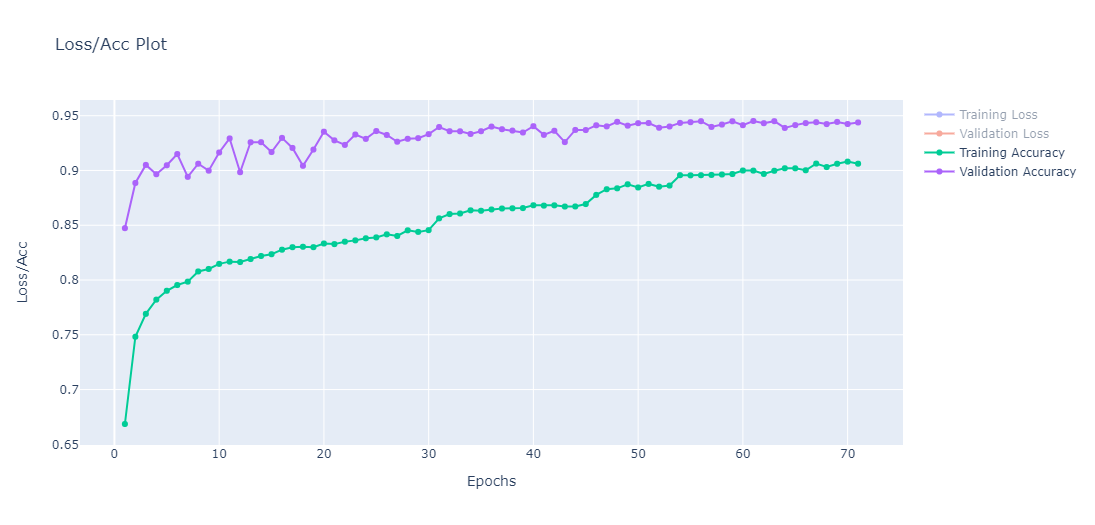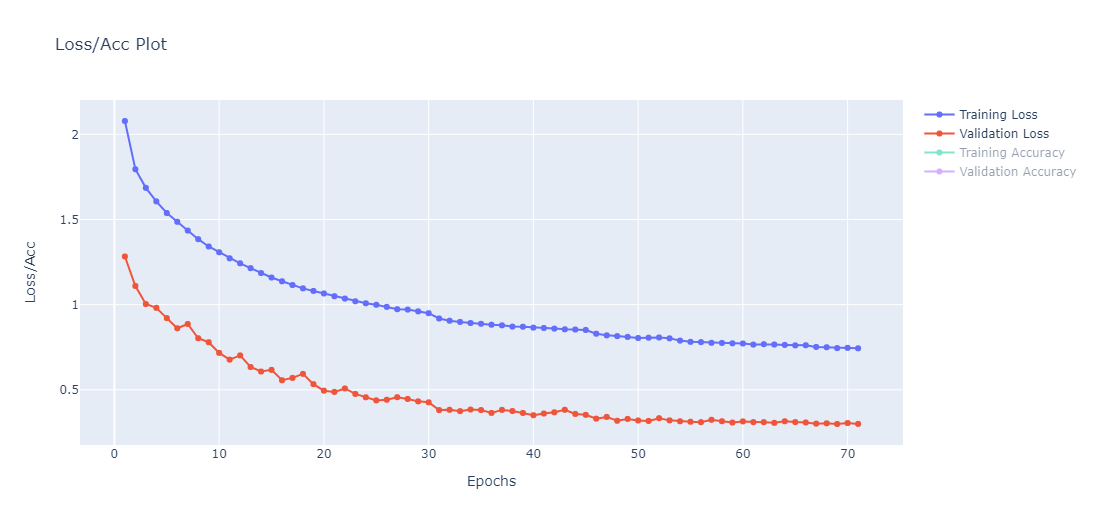

These tweaks don't appear to have a significant enough impact on the model however, and lead to a slightly worse validation accuracy.

### PyramidNet
To see if I can do better than my custom network while still having a lightweight architecture, I experiment with PyramidNet. Introduced in [Arxiv: Deep Pyramidal Residual Networks](https://arxiv.org/abs/1610.02915v4), the idea is to improve upon ResNets by gradually increasing the depth of the network layer by layer, instead of doubling the filters every set number of residual blocks (as is usually done).

The idea is that doing this results in improved generalization ability over ResNets, while having a lower parameter count. 

I choose this network to try as 
- it improves on the ResNet architecture
  - it uses a pre-activation as in Pre Activation Resnets (helping to improve gradient flow during backprop), while further improving on it by making changes to the PreAct Residual Block (Removing the activation after the first Conv in each block, and adding an extra Batch Normalization layer after the final convolution block in the main path of the residual block)
  - To reduce parameter count (since in a PyramidNet each residual block will typically require downsampling to have the residual connection), Average Pooling and Zero Padding (dimension wise) is adopted instead of the typical 1x1 Convolutions
- It has a relatively low parameter count in spite of it's depth due to the feature map dimension being gradually increased.

For the implementation, I took reference from the [Official PyTorch](https://github.com/jhkim89/PyramidNet) and [Unofficial Keras](https://github.com/eeccxin/PyramidNet-Keras) implementations, with modifications due to the flawed nature of the Keras implementation. To do the Zero-Padding on the channels, I made use of code from [this GitHub issue on the Keras repo](https://github.com/keras-team/keras/issues/2608)

In [ ]:
def pad_depth(x, desired_channels):
    y = K.zeros_like(x)
    new_channels = desired_channels - x.shape.as_list()[-1]
    y = y[..., :new_channels]
    return K.concatenate([x, y], axis=-1)

In [ ]:
class PNetLayer(Model):
  """
  """
  def __init__(self, num_channels, downsample=True, strides=1, activation='relu'):
    super(PNetLayer, self).__init__() # subclassing a layer
    self.activation = Activation(activation)
    self.bn_1 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform') # 
    self.conv_1 = Conv2D(num_channels, 3, strides=strides, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    self.bn_2 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
    self.conv_2 = Conv2D(num_channels, 3, strides=1, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    self.downsample = None
    if downsample:
      # self.downsample = Lambda(lambda x : x[:, ::2, ::2])
      self.downsample = AveragePooling2D(2, 2, padding="same")
    self.channel_padding = Lambda(pad_depth, arguments={"desired_channels" : num_channels}) # Conv2D(num_channels, 1, strides=strides,padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    self.bn_3 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
  def call(self, X):
    Y = self.bn_1(X)
    # Y = self.activation(Y) # Removing first ReLU was found to improve performance
    Y = self.conv_1(Y)
    Y = self.bn_2(Y)
    Y = self.activation(Y)
    Y = self.conv_2(Y)
    Y = self.bn_3(Y) # adding batch norm after final conv was found to further improve performance
    if self.downsample is not None:
      X = self.downsample(X)
    X = self.channel_padding(X) # shortcut connection
    Y += X
    return Y

In [ ]:
# class PNetBlock(Layer):
#     def __init__(self, num_channels, num_residuals, first_block=False, layer=PNetLayer, activation='relu',
#                  **kwargs):
#         super(PNetBlock, self).__init__(**kwargs)
#         self.residual_layers = []
#         for i in range(num_residuals):
#             if first_block:
#                 self.residual_layers.append(
#                     layer(num_channels[i], strides=1, activation=activation, downsample=False ))              
#             elif i == 0:
#                 self.residual_layers.append(
#                     layer(num_channels[i], strides=2, activation=activation))
#             else:
#                 self.residual_layers.append(layer(num_channels[i], strides=1, activation=activation))

#     def call(self, X):
#         for layer in self.residual_layers.layers:
#             X = layer(X)
#         return X

In [ ]:
def build_pyramidnet(optimizer, depth = 110, alpha = 48, loss='categorical_crossentropy',name = "PNet", layer=PNetLayer, activation='relu'):
  """

  """
  n = int((depth - 2) / 6)
  num_blocks = n * 3
  filters = np.floor(np.linspace(16, 16+alpha, num_blocks+1)).astype(int)
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs) 
  x = Conv2D(filters[0], 3, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')(x)
  k = 1
  for block_idx in range(1, 4):
    # x = PNetBlock(filters[(block_idx - 1) * (n) + 1:(block_idx * n) + 1], n, first_block=block_idx == 1, activation=activation, layer=layer)(x)
    for layer_idx in range(n):
      strides = 2 if layer_idx == 0 and not block_idx == 0 else 1
      downsample = strides != 1
      x = layer(filters[k], strides=strides, activation=activation, downsample=downsample)(x)
      k += 1
  x = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation(activation)(x)
  # Global Pooling
  x = GlobalAveragePooling2D()(x) 
  # Classification Head
  x = Dense(10, 'softmax', kernel_regularizer=l2(WEIGHT_DECAY), kernel_initializer='he_normal')(x)
  model = Model(inputs=inputs, outputs=x, name=name)
  model.compile(optimizer=optimizer,loss=loss, metrics=['accuracy'])
  print(model.summary())
  return model

#### PNet (Alpha = 48, Depth = 110)
I pick the smallest configuration of PyramidNet, at 1.7 million parameters (smaller than even my custom CNN which has 1.9 million parameters)

Alpha is a parameter which determines the rate at which the width of the network grows over time.

##### Without Data Augmentation

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_pyramidnet(optimizer, name="PNet_Fixed")

Model: "PNet_Fixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        4032      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 p_net_layer (PNetLayer)     (None, 14, 14, 16)        4800      
                                                                 
 p_net_layer_1 (PNetLayer)   (None, 14, 14, 17)        5

In [ ]:
train_ds, val_ds = set_up_data_aug(no_data_aug)
results, fig = evaluator.evaluate_model(model, train_ds, val_ds)

Training PNet_Fixed
Epoch 1/100
375/375 [==============================] - 48s 90ms/step - loss: 5.1589 - accuracy: 0.7167 - val_loss: 6.4615 - val_accuracy: 0.0957 - lr: 0.0100
Epoch 2/100
375/375 [==============================] - 30s 79ms/step - loss: 4.2829 - accuracy: 0.8655 - val_loss: 4.4164 - val_accuracy: 0.7415 - lr: 0.0100
Epoch 3/100
375/375 [==============================] - 30s 80ms/step - loss: 3.9473 - accuracy: 0.8851 - val_loss: 3.8261 - val_accuracy: 0.8832 - lr: 0.0100
Epoch 4/100
375/375 [==============================] - 30s 80ms/step - loss: 3.6541 - accuracy: 0.8977 - val_loss: 3.7008 - val_accuracy: 0.8541 - lr: 0.0100
Epoch 5/100
375/375 [==============================] - 31s 82ms/step - loss: 3.3904 - accuracy: 0.9053 - val_loss: 3.3382 - val_accuracy: 0.8867 - lr: 0.0100
Epoch 6/100
375/375 [==============================] - 31s 82ms/step - loss: 3.1512 - accuracy: 0.9122 - val_loss: 3.0966 - val_accuracy: 0.8933 - lr: 0.0100
Epoch 7/100
375/375 [===========

In [ ]:
display(results)

Epochs                                                               30
Batch Size                                                          128
Model Name                                                   PNet_Fixed
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                       1.1978
Test Loss                                                       1.29745
Train Acc                                                      0.956375
Test Acc                                                       0.913167
[Train - Test] Acc                                            0.0432084
dtype: object

In [ ]:
fig.show()

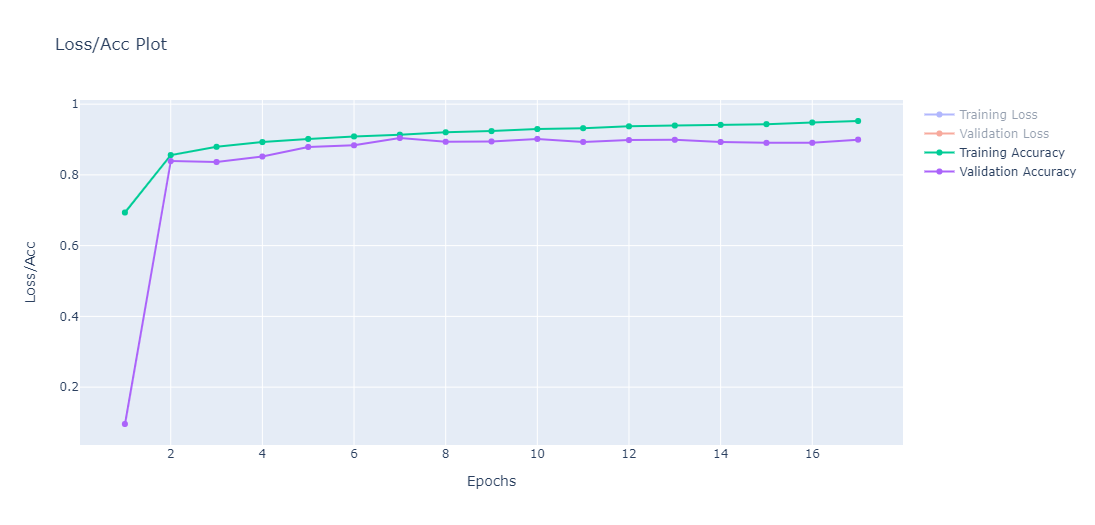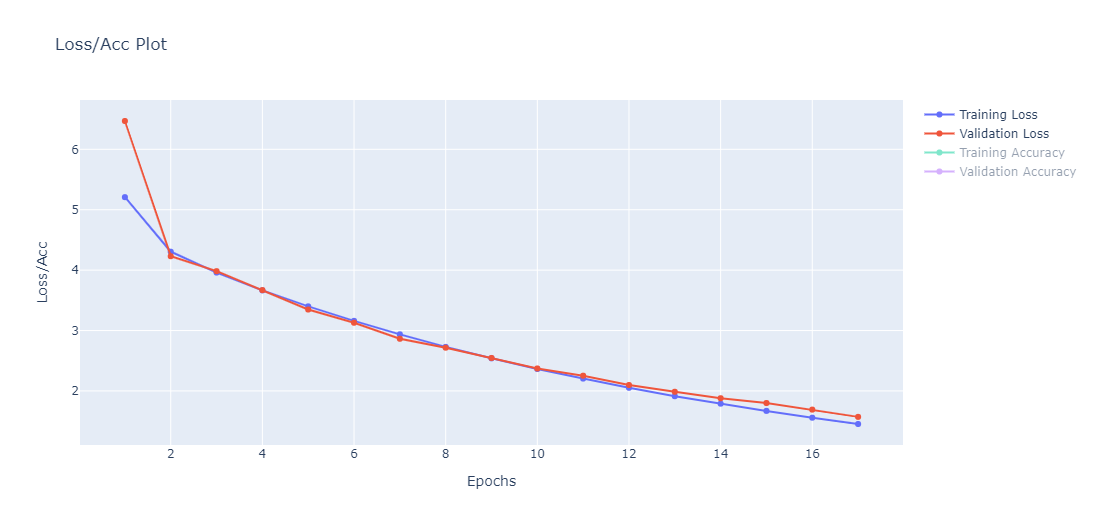

Here, I can see that the network is harder to optimize due to it's depth, so EarlyStopping kicks in since validation accuracy stops improving. As expected without data augmentation, the network does start to overfit.

In [ ]:
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/history.csv


##### With Basic Data Augmentation

In [ ]:
display(results)
fig.show()

Epochs                                                               29
Batch Size                                                          128
Model Name                                           PNet_DataAug_Fixed
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                      1.34392
Test Loss                                                       1.37822
Train Acc                                                         0.926
Test Acc                                                        0.90225
[Train - Test] Acc                                              0.02375
dtype: object

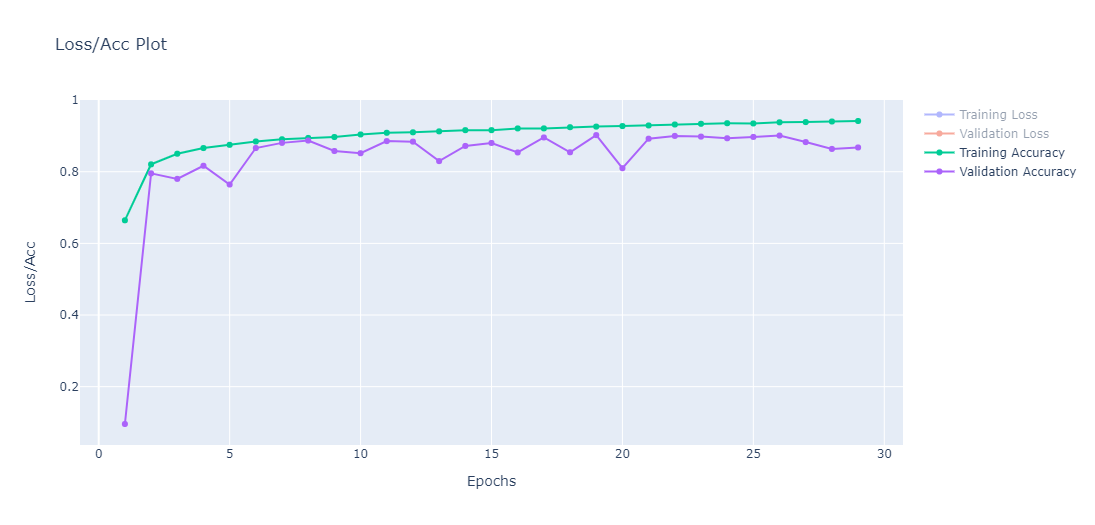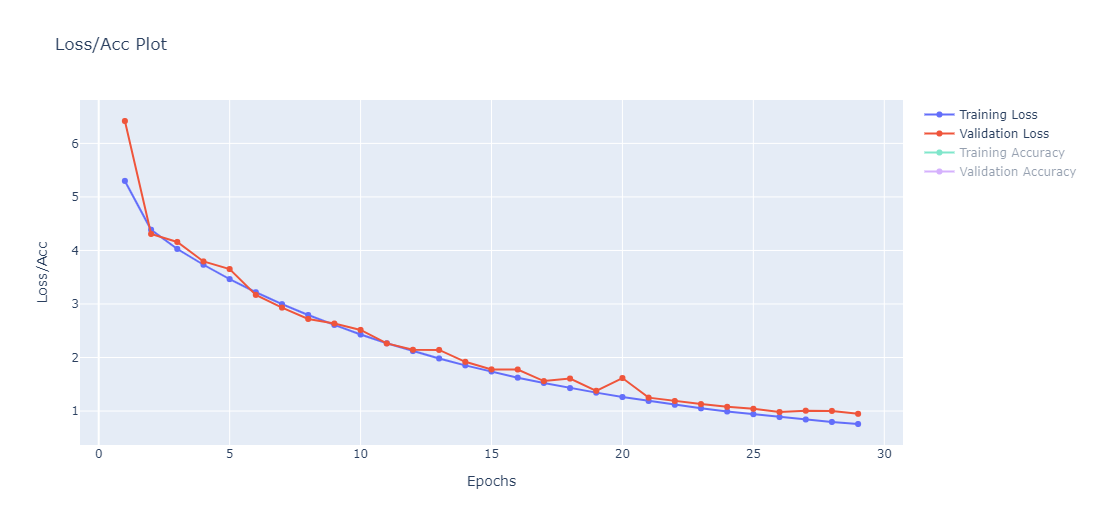

With data augmentation, overfitting is greatly reduced, but performance decreases overall. 

##### With CutMix Data Augmentation

In [ ]:
optimizer = SGD(learning_rate=LR, momentum=0.9)
model = build_pyramidnet(optimizer, name="PNet_Fixed_CutMix")
train_cutmix_ds, val_ds = set_up_cutmix()

Model: "PNet_Fixed_CutMix"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        4032      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 p_net_layer (PNetLayer)     (None, 14, 14, 16)        4800      
                                                                 
 p_net_layer_1 (PNetLayer)   (None, 14, 14, 17)  

In [ ]:
results, fig = evaluator.evaluate_model(model, train_cutmix_ds, val_ds)

Training PNet_Fixed_CutMix
Epoch 1/100
375/375 [==============================] - 56s 112ms/step - loss: 5.8526 - accuracy: 0.5251 - val_loss: 6.4126 - val_accuracy: 0.0957 - lr: 0.0100
Epoch 2/100
375/375 [==============================] - 39s 104ms/step - loss: 5.1021 - accuracy: 0.7072 - val_loss: 4.4687 - val_accuracy: 0.8056 - lr: 0.0100
Epoch 3/100
375/375 [==============================] - 41s 110ms/step - loss: 4.7394 - accuracy: 0.7339 - val_loss: 4.1416 - val_accuracy: 0.7900 - lr: 0.0100
Epoch 4/100
375/375 [==============================] - 42s 113ms/step - loss: 4.4329 - accuracy: 0.7459 - val_loss: 3.7187 - val_accuracy: 0.8553 - lr: 0.0100
Epoch 5/100
375/375 [==============================] - 41s 110ms/step - loss: 4.1578 - accuracy: 0.7569 - val_loss: 3.4541 - val_accuracy: 0.8697 - lr: 0.0100
Epoch 6/100
375/375 [==============================] - 43s 115ms/step - loss: 3.9048 - accuracy: 0.7685 - val_loss: 3.1823 - val_accuracy: 0.8846 - lr: 0.0100
Epoch 7/100
375/375

In [ ]:
display(results)
fig.show()

Epochs                                                               41
Batch Size                                                          128
Model Name                                            PNet_Fixed_CutMix
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                      1.34283
Test Loss                                                      0.757292
Train Acc                                                      0.824458
Test Acc                                                          0.923
[Train - Test] Acc                                           -0.0985416
dtype: object

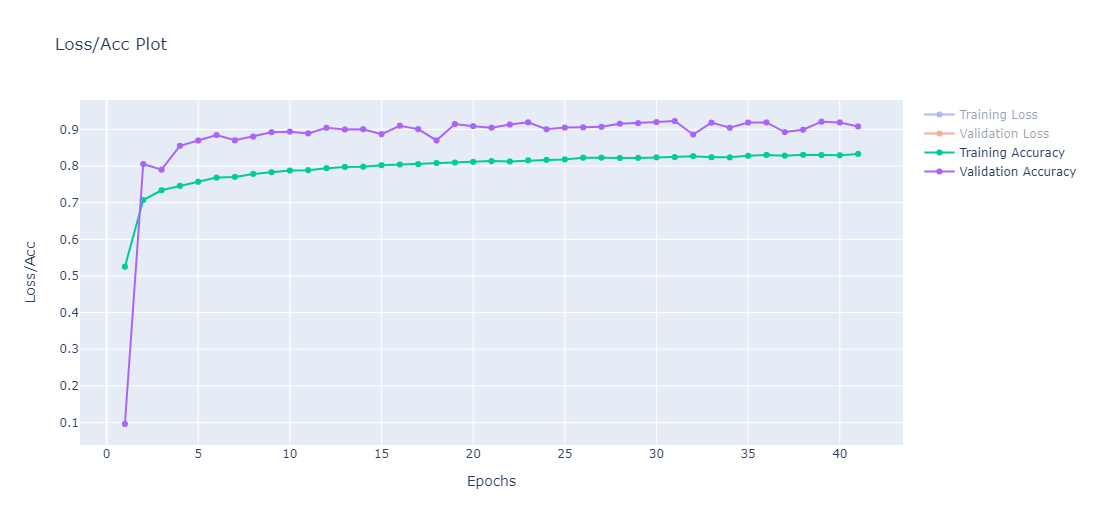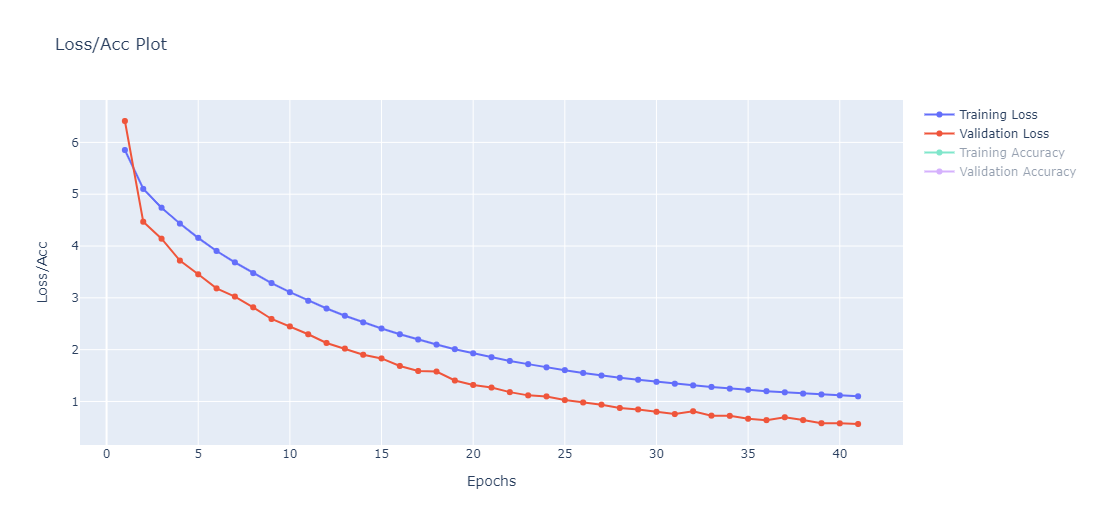

Well, the results seem disappointing as while CutMix manages to boost the validation accuracy, it still doesn't surpass that of our custom network. In this case, I suspect it may be a matter of better training methods being required due to the deeper network being harder to optimize. I suspect this as I've tried using an Adam optimizer (which requires less tuning to do well), and it was able to converge to a better result (although it still didn't match the performance of the custom CNN with Cutmix)

Now at this point I have a few ways to move on
1. Go bigger and increase alpha
2. Go tune the training process to see if I can get it to fully converge


In [ ]:
evaluator.return_history()

,Model Name,Train Acc,Test Acc,[Train - Test] Acc,Remarks
0,Deep_ANN_1,0.910812,0.879917,0.030896,Overfitting
1,Deep_ANN_1_DataAug,0.876979,0.848417,0.028562,Worse performance overall
2,Deep_ANN_Regularized_1,0.903771,0.879000,0.024771,NaN
3,VGGNet,0.999979,0.934500,0.065479,NaN
4,VGGNet_BasicDataAug,0.952458,0.918833,0.033625,NaN
5,VGGNet_CutMix,0.881771,0.946167,-0.064396,NaN
6,PNet,0.913646,0.904250,0.009396,
7,PNet_Cutmix,0.830458,0.923833,-0.093375,
8,PNet_Adam_CutMix,0.856229,0.936083,-0.079854,
9,PNet_DataAug_Fixed,0.926000,0.902250,0.023750,


**Note: `_Fixed` meant that I fixed the flawed implementation of downsampling in the original implementation**

In [ ]:
evaluator.save_history()

History saved to /content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/history.csv


## Model Improvement
It seems that for this task, the custom CNN built appears to outperform PyramidNet. Although PyramidNet offers a lot of architectural improvements, it appears to be more difficult to train, leading to a suboptimal result. To see which of the two networks is better, I decide to perform tuning of the optimizer.

### Tuning Custom CNN
To tune my custom CNN I do the following
- I make use of a Cosine Annealing learning rate scheduler 
- I use Keras Tuner to do a search for the optimal learning rate and weight decay

Due to the limited GPU resources I have in Google Colab (and runtime restrictions), I am limited in what hyperparameters I can tune.

In [48]:
class VGGConvLayer(Model):
  """
  Basic Conv Layer, with Batch Normalization done before activation
  """
  def __init__(self, filters , activation = ReLU, weight_decay = WEIGHT_DECAY):
    super(VGGConvLayer, self).__init__() # subclassing a layer
    self.layer_conv_1 = Conv2D(filters, (3, 3), padding='same', strides=1, kernel_regularizer=l2(weight_decay), use_bias=False)
    self.layer_bn_1 = BatchNormalization()
    self.layer_activation_1 = activation()

  def call(self, X):
    X = self.layer_conv_1(X)
    X = self.layer_bn_1(X)
    return self.layer_activation_1(X)

class VGGConvBlock(Layer):
  def __init__(self, no_layers, filters, activation=ReLU, weight_decay = WEIGHT_DECAY):
    super(VGGConvBlock, self).__init__()
    self.conv_block = Sequential()
    for _ in range(no_layers):
      self.conv_block.add(
          VGGConvLayer(filters, activation=activation, weight_decay = weight_decay)
      )
    self.conv_block.add(MaxPool2D(strides=2))

  def call(self, X):
    return self.conv_block(X)

In [ ]:
def tune_vggnet(hp):
  """
  """
  weight_decay = hp.Float("weight_decay", min_value=3e-4, max_value=1e-2, sampling="log")
  learning_rate = hp.Float("learning_rate", min_value=1e-3, max_value=1e-1, sampling="log")
  scheduler = CosineDecay(learning_rate, 50 * steps_per_epoch)
  optimizer = SGD(learning_rate=scheduler, momentum=0.9)
  inputs = Input(IMG_SIZE) 
  x = pre_processing_v1(inputs)
  x = VGGConvBlock(2, 32, weight_decay=weight_decay)(x) 
  x = VGGConvBlock(2, 64, weight_decay=weight_decay)(x)
  x = VGGConvBlock(3, 128, weight_decay=weight_decay)(x)
  x = VGGConvBlock(3, 256, weight_decay=weight_decay)(x)
  # Global Pooling
  x = GlobalAveragePooling2D()(x) 
  # Classification Head
  x = Dropout(0.3)(x)
  x = Dense(10, 'softmax')(x)
  model = Model(inputs=inputs, outputs=x)
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()

The tuning algorithm used is Hyperband, a variation on random search that uses aggressive successive halving of the search space to efficiently find optimal hyperparameters.

In [ ]:
tuner = kt.Hyperband(tune_vggnet, objective="val_accuracy", max_epochs=50, overwrite=True, project_name="fashionmnist_vgg")

In [ ]:
tuner.search(
    train_cutmix_ds, validation_data=val_ds, epochs=60, batch_size=BATCH_SIZE,callbacks=[
                                                                                         EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
    ]
)
tuner.results_summary(num_trials=3)

Trial 90 Complete [00h 04m 03s]
val_accuracy: 0.9482499957084656

Best val_accuracy So Far: 0.9486666917800903
Total elapsed time: 01h 13m 03s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./fashionmnist_vgg
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
weight_decay: 0.00080764733135439
learning_rate: 0.03114165676160948
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9486666917800903
Trial summary
Hyperparameters:
weight_decay: 0.0004430094766325844
learning_rate: 0.022466970035351193
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9482499957084656
Trial summary
Hyperparameters:
weight_decay: 0.0003195527510188086
learning_rate: 0.019361428090391482
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: f9498a30fe14f132cede48948538ce3d
Score: 0.9433333277702332


In [49]:
def build_tuned_vggnet(name="VGGNet_Tuned_Cutmix"):
  """
  A modified and cut down version of VGG16, using GlobalPooling, and a modified VGGBlock
  """
  inputs = Input(IMG_SIZE) # Input
  weight_decay = 0.00080764733135439
  scheduler = CosineDecay(0.03114165676160948, 50 * steps_per_epoch)
  optimizer = SGD(learning_rate=scheduler, momentum=0.9)
  x = pre_processing_v1(inputs)
  x = VGGConvBlock(2, 32, weight_decay=weight_decay)(x) # compared to vgg, we use fewer filters
  x = VGGConvBlock(2, 64, weight_decay=weight_decay)(x)
  x = VGGConvBlock(3, 128, weight_decay=weight_decay)(x)
  x = VGGConvBlock(3, 256, weight_decay=weight_decay)(x)
  # Global Pooling
  x = GlobalAveragePooling2D()(x) 
  # Classification Head
  x = Dropout(0.3)(x)
  x = Dense(10, 'softmax')(x)
  model = Model(inputs=inputs, outputs=x, name=name)
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()

In [ ]:
model = build_tuned_vggnet()

Model: "VGGNet_Tuned_Cutmix"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 28, 28, 28)       57        
 n)                                                              
                                                                 
 vgg_conv_block_4 (VGGConvBl  (None, 14, 14, 32)       17536     
 ock)                                                            
                                                                 
 vgg_conv_block_5 (VGGConvBl  (None, 7, 7, 64)         55808     
 ock)                                                            
                                                                 
 vgg_conv_block_6 (VGGConvBl  (None, 3, 3, 128)        370176    
 ock)                                          

In [ ]:
results, fig = evaluator.evaluate_model(model, train_cutmix_ds, val_ds, callbacks=[
  EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)
])

Training VGGNet_Tuned_Cutmix
Epoch 1/100
375/375 [==============================] - 6s 14ms/step - loss: 2.4616 - accuracy: 0.5929 - val_loss: 1.9513 - val_accuracy: 0.6753
Epoch 2/100
375/375 [==============================] - 5s 12ms/step - loss: 1.7987 - accuracy: 0.7392 - val_loss: 1.3624 - val_accuracy: 0.8267
Epoch 3/100
375/375 [==============================] - 5s 12ms/step - loss: 1.5226 - accuracy: 0.7659 - val_loss: 0.9680 - val_accuracy: 0.8681
Epoch 4/100
375/375 [==============================] - 5s 12ms/step - loss: 1.3599 - accuracy: 0.7739 - val_loss: 0.8648 - val_accuracy: 0.8457
Epoch 5/100
375/375 [==============================] - 5s 13ms/step - loss: 1.2434 - accuracy: 0.7810 - val_loss: 0.6416 - val_accuracy: 0.8947
Epoch 6/100
375/375 [==============================] - 5s 12ms/step - loss: 1.1743 - accuracy: 0.7867 - val_loss: 0.6578 - val_accuracy: 0.8610
Epoch 7/100
375/375 [==============================] - 5s 12ms/step - loss: 1.1167 - accuracy: 0.7933 - val

In [ ]:
display(results)
fig.show()

Epochs                                                               69
Batch Size                                                          128
Model Name                                          VGGNet_Tuned_Cutmix
Remarks                                                                
Model Path            /content/drive/MyDrive/Data/DELE CA1/Fashion M...
Train Loss                                                     0.739758
Test Loss                                                      0.260758
Train Acc                                                      0.896187
Test Acc                                                       0.947417
[Train - Test] Acc                                           -0.0512292
dtype: object

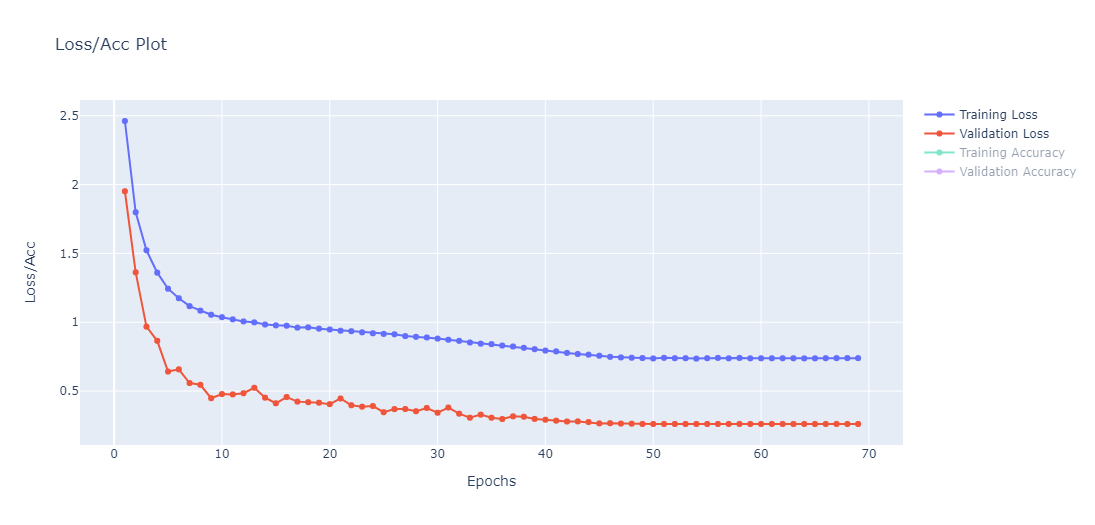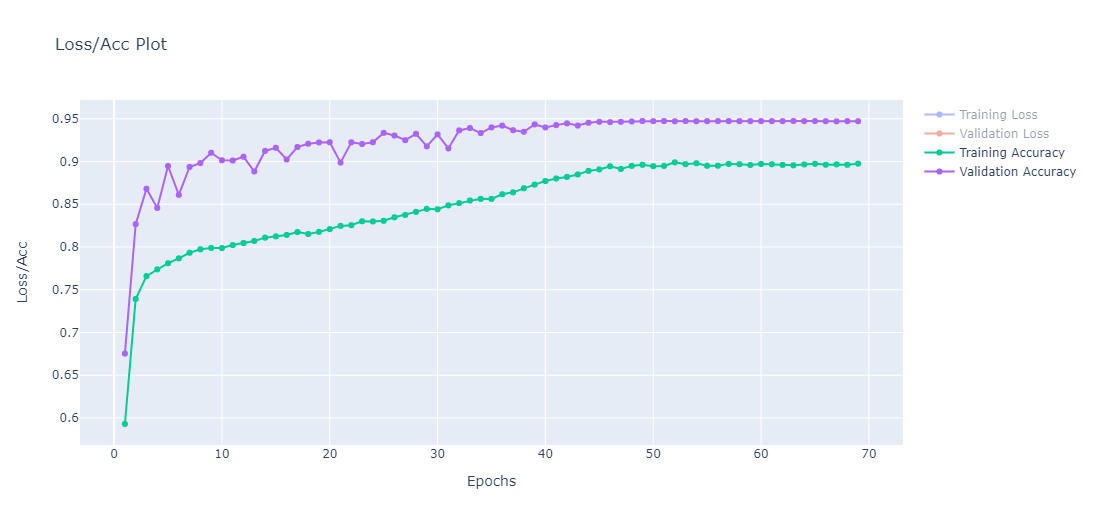

I am able to make some marginal improvements through my tuning, which I do suspect is reaching the limit of what this model architecture is capable of doing. Due to the cosine decay, the learning rate becomes very small after 50 epochs, so the network stops learning. With that, I suspect that a different scheduler or decay steps would allow the network to improve a little bit further.

### Tuning PNet

In [ ]:
# code adapted for Keras https://github.com/szagoruyko/wide-residual-networks/blob/master/models/wide-resnet.lua
class PNetLayer(Model):
  """
  """
  def __init__(self, num_channels, downsample=True, strides=1, activation='relu', WEIGHT_DECAY=WEIGHT_DECAY):
    super(PNetLayer, self).__init__() # subclassing a layer
    self.activation = Activation(activation)
    self.bn_1 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform') # 
    self.conv_1 = Conv2D(num_channels, 3, strides=strides, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    self.bn_2 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
    self.conv_2 = Conv2D(num_channels, 3, strides=1, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    self.downsample = None
    if downsample:
      # self.downsample = Lambda(lambda x : x[:, ::2, ::2])
      self.downsample = AveragePooling2D(2, 2, padding="same")
    self.channel_padding = Lambda(pad_depth, arguments={"desired_channels" : num_channels}) # Conv2D(num_channels, 1, strides=strides,padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
    self.bn_3 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
  def call(self, X):
    Y = self.bn_1(X)
    # Y = self.activation(Y) # Removing first ReLU was found to improve performance
    Y = self.conv_1(Y)
    Y = self.bn_2(Y)
    Y = self.activation(Y)
    Y = self.conv_2(Y)
    Y = self.bn_3(Y) # adding batch norm after final conv was found to further improve performance
    if self.downsample is not None:
      X = self.downsample(X)
    X = self.channel_padding(X) # shortcut connection
    Y += X
    return Y

In [ ]:
def tune_pyramidnet(hp):
  """

  """
  weight_decay = hp.Float("weight_decay", min_value=3e-4, max_value=1e-2, sampling="log")
  learning_rate = hp.Float("learning_rate", min_value=1e-3, max_value=1e-1, sampling="log")
  scheduler = CosineDecayRestarts(learning_rate, 10 * steps_per_epoch)
  optimizer = SGD(learning_rate=scheduler, momentum=0.9)
  depth = 110
  alpha = 48
  n = int((depth - 2) / 6)
  num_blocks = n * 3
  filters = np.floor(np.linspace(16, 16+alpha, num_blocks+1)).astype(int)
  inputs = Input(IMG_SIZE) # Input
  x = pre_processing_v1(inputs) 
  x = Conv2D(filters[0], 3, padding="same", kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')(x)
  k = 1
  for block_idx in range(1, 4):
    # x = PNetBlock(filters[(block_idx - 1) * (n) + 1:(block_idx * n) + 1], n, first_block=block_idx == 1, activation=activation, layer=layer)(x)
    for layer_idx in range(n):
      strides = 2 if layer_idx == 0 and not block_idx == 0 else 1
      downsample = strides != 1
      x = PNetLayer(filters[k], strides=strides, activation='relu', downsample=downsample)(x)
      k += 1
  x = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')(x)
  x = Activation('relu')(x)
  # Global Pooling
  x = GlobalAveragePooling2D()(x) 
  # Classification Head
  x = Dense(10, 'softmax', kernel_regularizer=l2(WEIGHT_DECAY), kernel_initializer='he_normal')(x)
  model = Model(inputs=inputs, outputs=x)
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
train_cutmix_ds, val_ds = set_up_cutmix()

In [ ]:
tuner = kt.Hyperband(tune_pyramidnet, objective="val_accuracy", max_epochs=100, overwrite=True, project_name="fashionmnist_pnet")

In [ ]:
tuner.search(
    train_cutmix_ds, validation_data=val_ds, epochs=100, batch_size=BATCH_SIZE,callbacks=[
                                                                                         EarlyStopping(monitor="val_accuracy", patience=20, restore_best_weights=True)
    ]
)
tuner.results_summary(num_trials=3)

Trial 253 Complete [00h 44m 05s]
val_accuracy: 0.937416672706604

Best val_accuracy So Far: 0.9429166913032532
Total elapsed time: 20h 28m 25s

Search: Running Trial #254

Hyperparameter    |Value             |Best Value So Far 
weight_decay      |0.00051687        |0.00085155        
learning_rate     |0.0011385         |0.049829          
tuner/epochs      |100               |100               
tuner/initial_e...|0                 |34                
tuner/bracket     |0                 |4                 
tuner/round       |0                 |4                 

Epoch 1/100
375/375 [==============================] - 48s 88ms/step - loss: 6.5812 - accuracy: 0.3036 - val_loss: 6.6041 - val_accuracy: 0.1027
Epoch 2/100
271/375 [====================>.........] - ETA: 7s - loss: 6.3402 - accuracy: 0.4491

In this case, due to limited runtime on Colab, I am unable to complete the hyperparameter search, but it appears as if we can't find a suitable learning rate that beats the custom CNN.

It is clear that of the two models, the custom CNN is the clear winner.
- It is faster to converge
- It performs better in validation

While I suspect that the PyramidNet could perform better given sufficient tuning, I do not have the computational resources to tune the model further, so I will continue on with the custom CNN

## Evaluating the Final Model
Now is the time to evaluate my final model. To ensure it generalizes well, I want to ensure a accuracy on the testing set consistent with that on the validation set.

In [58]:
final_model = tf.keras.models.load_model("/content/drive/MyDrive/Data/DELE CA1/Fashion MNIST/SavedModels/VGGNet_Tuned_Cutmix")

### Testing Set 

In [59]:
final_model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.2718 - accuracy: 0.9477


[0.27180784940719604, 0.947700023651123]

Our final accuracy on the test set is 94.77% 

This is extremely close to the validation set results, suggesting that our model does not overfit and can generalize well without issues.

In [64]:
test_preds = np.argmax(final_model.predict(X_test), axis=1)

In [65]:
test_preds.shape

(10000,)

In [61]:
from sklearn.metrics import classification_report

In [67]:
report = classification_report(
    np.argmax(y_test, axis=1), test_preds, target_names=class_labels.values()
)

In [69]:
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.90      0.90      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.93      0.93      0.93      1000
       Dress       0.94      0.94      0.94      1000
        Coat       0.91      0.93      0.92      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.86      0.83      0.84      1000
     Sneaker       0.97      0.99      0.98      1000
         Bag       0.99      1.00      0.99      1000
  Ankle boot       0.98      0.97      0.98      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



From looking at the classification report, we can see that
- The distribution of classes in the test set is perfectly balanced
- The model does badly on shirts and coats, and very well on shoes (Sneakers, Sandals, Boots)
- This likely reflects on the fact that shirts and coats have similar appearances, whereas it is likely that the different types of shoes have more distinct appearances

### Error Analysis
Now is a time to gain a better understanding of our model's mistakes

In [76]:
wrong_example_mask = (np.argmax(y_test, axis=1) != test_preds)
X_test_wrong = X_test[wrong_example_mask]
y_test_wrong = np.argmax(y_test[wrong_example_mask], axis=1)
y_pred_wrong = test_preds[wrong_example_mask]

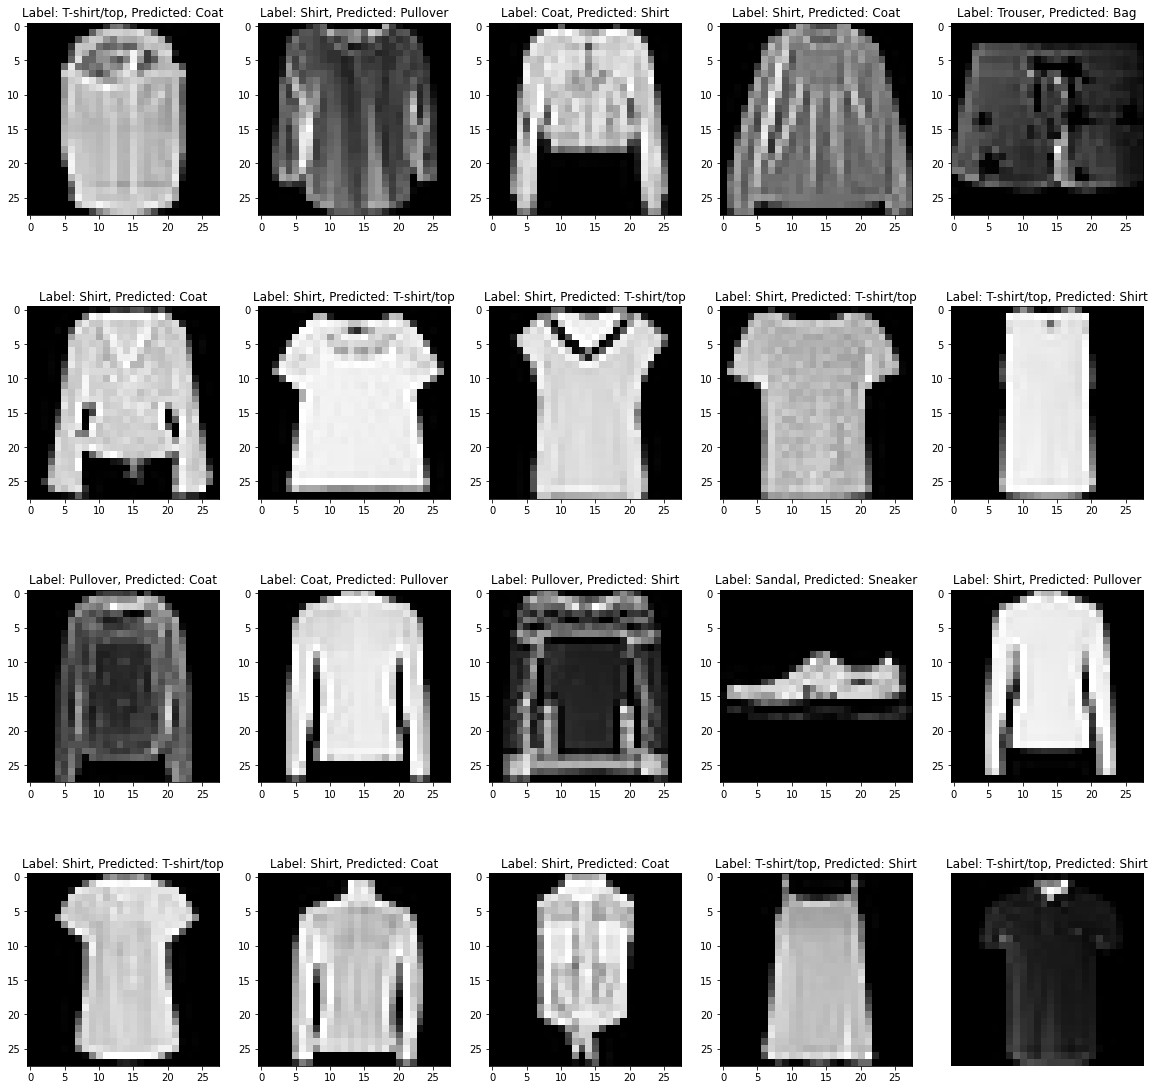

In [77]:
random_idxs = np.random.choice(X_test_wrong.shape[0], 20, replace=False)

fig, ax = plt.subplots(4, 5, figsize=(20, 20))
plt.axis("off")
for idx, subplot in zip(random_idxs, ax.ravel()):
  pred = class_labels[y_pred_wrong[idx]]
  actual = class_labels[y_test_wrong[idx]]
  subplot.imshow(X_test_wrong[idx], cmap='gray')
  subplot.set_title(f"Label: {actual}, Predicted: {pred}")

When looking at a sample of the examples where the model made a wrong prediction, we can see that there is a common thread:
- The low pixel resolution makes it ambguious even to a human what the correct class is. For instance, the first image looks like a hoodie (but is actually a shirt)

So, it does appear that the mistakes the model is making is actually quite reasonable. In fact, according to benchmarks done to measure real human performance on the Fashion MNIST dataset, [human level accuracy by non-fashion experts was 83.5%](https://github.com/zalandoresearch/fashion-mnist). So, the model is actually doing quite well.

# Summary
In summary, I experimented with various models, and found that a custom built CNN with batch normalization and CutMix data augmentation performed the best with the least overfitting.

- The final model has a high validation accuracy, and does well on the testing set, suggesting that it does not overfit
- The parts where it does badly are those examples where the images are ambigious themselves, suggesting that the poor resolution of the images hampers the ability of the model to learn
- Nevertheless, there is room for improvement
  - In my experiments, I tried architectures using Residual Connections (PyramidNet, -- also tried other architectures like ResNets and WideResNets, but the result has been removed due to unsatisfactory result but can be seen by going to a previous version of the Colab Notebook using version history feature)
  - I found that despite them being stronger in theory, in practice they were harder to optimize or providing marginal improvement for large increase in parameter cost even with hyperparameter tuning
  - Perhaps with more experimentation, I might find them to perform better, but I am satisified with the current model that I have, as it is fairly light weight (in comparison to other models)
  - There is also more room for exploration in terms of the learning rate scheduler, optimizer and certain architectural improvements
    - Several (AdaBelief, Stochastic Depth, Squeeze and Excite Blocks) were tried but found to be unsatisfactory, but may have needed more tuning to show their true benefit (apologies for not including them in the final notebook, had removed them to simplify the notebook structure. If necessary, the version history on Colab can be used to revert to earlier versions which included these experiments)